In [1]:
library("devtools")
library(forcats)
library(tidyverse)
library(ggrepel)
library(dplyr)



Loading required package: usethis

── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0.9000 ──
✔ dplyr     1.1.1     ✔ readr     2.1.4
✔ ggplot2   3.4.1     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
sb_metadata <- read_delim("/home/jpm73279/Mendieta_et_al_comparative_single_cell/metrics/annotations/Sb_annot_final/Sb.leaf_annot.V5.meta.frozen.txt")
zm_metadata <- read_delim("/home/jpm73279/Mendieta_et_al_comparative_single_cell/metrics/annotations/Zm_annot_final/Zm.leaf_annot.V5.meta.frozen.txt")

Rows: 15301 Columns: 39
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (19): cellID, sampleID, d.type, LouvainCluster_t, louvain_clusters_sub, ...
dbl (20): total, tss, acrs, ptmt, nSites, log10nSites, pTSS, FRiP, pOrg, tss...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 16060 Columns: 34
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (13): cellID, sampleID, d.type, Zm_v4_annot, Zm_v4_annot.subcluster_anno...
dbl (21): total, tss, acrs, ptmt, nSites, log10nSites, pTSS, FRiP, pOrg, tss...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quie

In [3]:

columns_acrs <- c("chrom", "start", "stop", "acr_name", "freq")
sb_acr_number <- read_delim("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/replicate_analysis_one_off/annotate_bulk/Sb.final_acr_classification.no_exons.all_cts.ACRs.bed", delim="\t", col_names = columns_acrs)  %>% 
    separate(col = acr_name, 
           into = c("acr_number","cell_type"), 
           sep = ";", 
           remove = FALSE)  %>% 
    mutate(species = "sb") 

zm_acr_number <- read_delim("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/replicate_analysis_one_off/annotate_bulk/Zm.final_acr_classification.no_exons.final.all_cts.ACRs.bed", delim="\t",col_names = columns_acrs)  %>% 
    separate(col = acr_name, 
           into = c("acr_number","cell_type"), 
           sep = ";", 
           remove = FALSE)  %>% 
    mutate(species = "zm")


sb_acr_number_count <- sb_acr_number  %>% 
    group_by(cell_type, species)  %>% 
    summarise(acr_number = n())  %>%
       separate(col = cell_type, 
           into = c("cell_type","ncells"), 
           sep = "_n_cell_", 
           remove = FALSE)  %>% 
    mutate(cell_type = case_when(cell_type == "mesophyll_desc_developing" ~ "mesophyll;developing", 
                                TRUE ~ cell_type))
    

zm_acr_number_count <- zm_acr_number  %>% 
    group_by(cell_type, species)  %>% 
    summarise(acr_number = n())  %>% 
       separate(col = cell_type, 
           into = c("cell_type","ncells"), 
           sep = "_n_cell_", 
           remove = FALSE)  %>% 
    mutate(cell_type = case_when(cell_type == "mesophyll_desc_developing" ~ "mesophyll;developing", 
                                TRUE ~ cell_type))


Rows: 12816 Columns: 5
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): chrom, acr_name
dbl (3): start, stop, freq

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 8852 Columns: 5
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): chrom, acr_name
dbl (3): start, stop, freq

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'cell_type'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'cell_type'. You can override using the `.groups` argument.


In [5]:
zm_acr_number_count

species cell_type             ncells acr_number
1 zm      bundle_sheath         2878    721      
2 zm      companion_cells       689     709      
3 zm      epidermis             3488   1090      
4 zm      mesophyll;developing  510    1463      
5 zm      mesophyll             4657   1025      
6 zm      phloem_sieve_elements 1471   1026      
7 zm      procambial_meristem   346    1503      
8 zm      protoderm             2021   1315

In [6]:
sb_summarised_celltype <- sb_metadata  %>% 
    group_by(final_annotation)  %>% 
    summarise(ncell = n())  %>% 
    mutate(species = "sb")  %>% 
    left_join(., sb_acr_number_count, by = c("species" = "species", "final_annotation" = "cell_type"))  %>% 
    rename("cell_type" = final_annotation)

zm_summarised_celltype <- zm_metadata  %>% 
    group_by(final_annotation)  %>% 
    summarise(ncell = n())  %>% 
    mutate(species = "zm")  %>% 
    left_join(., zm_acr_number_count, by = c("species" = "species", "final_annotation" = "cell_type"))  %>% 
    rename("cell_type" = final_annotation)




`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_text_repel).”


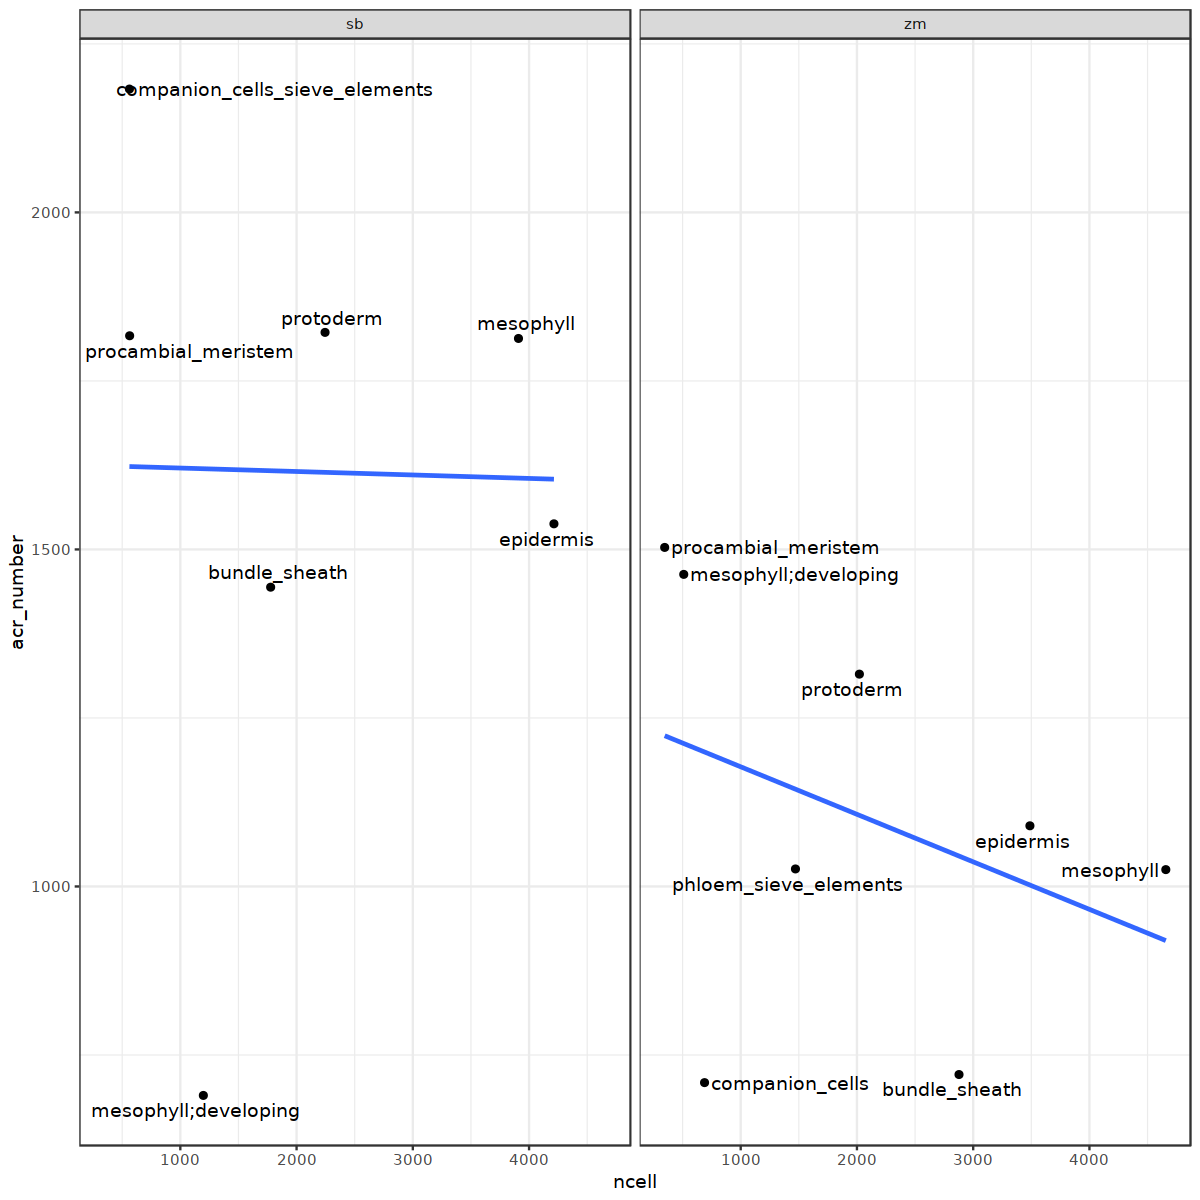

In [7]:
combined <- bind_rows(zm_summarised_celltype, sb_summarised_celltype)


ggplot(combined, aes(ncell, acr_number, label=cell_type)) + geom_point() + 
facet_grid(.~species) + geom_text_repel() + geom_smooth(method = "lm", se = FALSE) + 
theme_bw()
 

In [8]:
combined

cell_type                      ncell species ncells acr_number
1  bundle_sheath                  2878  zm      2878    721      
2  companion_cells                 689  zm      689     709      
3  epidermis                      3488  zm      3488   1090      
4  mesophyll                      4657  zm      4657   1025      
5  mesophyll;developing            510  zm      510    1463      
6  phloem_sieve_elements          1471  zm      1471   1026      
7  procambial_meristem             346  zm      346    1503      
8  protoderm                      2021  zm      2021   1315      
9  bundle_sheath                  1777  sb      1777   1444      
10 companion_cells_sieve_elements  562  sb      562    2183      
11 epidermis                      4214  sb      4214   1538      
12 mesophyll                      3909  sb      3909   1813      
13 mesophyll;developing           1198  sb      1198    690      
14 procambial_meristem             564  sb      564    1817      
15 protoderm                      2245  sb      2245   1822      
16 unknown;1                       832  sb      NA       NA

In [9]:
calculate_totaol <- combined  %>% 
    group_by(species)  %>% 
    dplyr::summarise(total_ctsACRs = sum(acr_number, na.rm=TRUE))


combined_acrs <-left_join(combined, calculate_totaol, by = c("species"))  %>% 
    rowwise()  %>% 
    mutate(calculated_prop_of_cts = (acr_number/total_ctsACRs) * 100)

combined_acrs

cell_type                      ncell species ncells acr_number total_ctsACRs
1  bundle_sheath                  2878  zm      2878    721        8852        
2  companion_cells                 689  zm      689     709        8852        
3  epidermis                      3488  zm      3488   1090        8852        
4  mesophyll                      4657  zm      4657   1025        8852        
5  mesophyll;developing            510  zm      510    1463        8852        
6  phloem_sieve_elements          1471  zm      1471   1026        8852        
7  procambial_meristem             346  zm      346    1503        8852        
8  protoderm                      2021  zm      2021   1315        8852        
9  bundle_sheath                  1777  sb      1777   1444       11307        
10 companion_cells_sieve_elements  562  sb      562    2183       11307        
11 epidermis                      4214  sb      4214   1538       11307        
12 mesophyll                      3909  sb      3909   1813       11307        
13 mesophyll;developing           1198  sb      1198    690       11307        
14 procambial_meristem             564  sb      564    1817       11307        
15 protoderm                      2245  sb      2245   1822       11307        
16 unknown;1                       832  sb      NA       NA       11307        
   calculated_prop_of_cts
1   8.145052             
2   8.009489             
3  12.313601             
4  11.579304             
5  16.527338             
6  11.590601             
7  16.979214             
8  14.855400             
9  12.770850             
10 19.306624             
11 13.602193             
12 16.034315             
13  6.102414             
14 16.069691             
15 16.113912             
16        NA

In [10]:

colors_large <- c("#DEA940","#A2A763","#D6EEBE","#5894D4","#6AAD51","#6C8686","#FFD92F", "#7f2201","#b53310",
                         "#E7673B","#FB9A99","#E31A1C","#FDBF6F","#CAB2D6","#386CB0","#FFFFB3", "#5dead5","#c11577",
                         "#CCCCCC", "#7570B3","#B15928", "#6A3D9A", "#d87c6a", "#0060e8", "#84c5ff", "#ffd460", "#d81397")


factor_order <- c("broadly_accessible",
                  'companion_cells_sieve_elements',
                  'phloem_sieve_elements',
'companion_cells',
'sieve_elements',
'bundle_sheath',
'developing_mesophyll',
'epidermis',
'mesophyll',
'procambium',
'protoderm')



In [11]:
combined_acrs

cell_type                      ncell species ncells acr_number total_ctsACRs
1  bundle_sheath                  2878  zm      2878    721        8852        
2  companion_cells                 689  zm      689     709        8852        
3  epidermis                      3488  zm      3488   1090        8852        
4  mesophyll                      4657  zm      4657   1025        8852        
5  mesophyll;developing            510  zm      510    1463        8852        
6  phloem_sieve_elements          1471  zm      1471   1026        8852        
7  procambial_meristem             346  zm      346    1503        8852        
8  protoderm                      2021  zm      2021   1315        8852        
9  bundle_sheath                  1777  sb      1777   1444       11307        
10 companion_cells_sieve_elements  562  sb      562    2183       11307        
11 epidermis                      4214  sb      4214   1538       11307        
12 mesophyll                      3909  sb      3909   1813       11307        
13 mesophyll;developing           1198  sb      1198    690       11307        
14 procambial_meristem             564  sb      564    1817       11307        
15 protoderm                      2245  sb      2245   1822       11307        
16 unknown;1                       832  sb      NA       NA       11307        
   calculated_prop_of_cts
1   8.145052             
2   8.009489             
3  12.313601             
4  11.579304             
5  16.527338             
6  11.590601             
7  16.979214             
8  14.855400             
9  12.770850             
10 19.306624             
11 13.602193             
12 16.034315             
13  6.102414             
14 16.069691             
15 16.113912             
16        NA

Warning message:
“4 unknown levels in `f`: broadly_accessible, sieve_elements, developing_mesophyll, and procambium”
Warning message:
“4 unknown levels in `f`: broadly_accessible, sieve_elements, developing_mesophyll, and procambium”
Warning message:
“4 unknown levels in `f`: broadly_accessible, sieve_elements, developing_mesophyll, and procambium”
Warning message:
“4 unknown levels in `f`: broadly_accessible, sieve_elements, developing_mesophyll, and procambium”
Warning message:
“4 unknown levels in `f`: broadly_accessible, sieve_elements, developing_mesophyll, and procambium”
Warning message:
“4 unknown levels in `f`: broadly_accessible, sieve_elements, developing_mesophyll, and procambium”
Warning message:
“4 unknown levels in `f`: broadly_accessible, sieve_elements, developing_mesophyll, and procambium”
Warning message:
“4 unknown levels in `f`: broadly_accessible, sieve_elements, developing_mesophyll, and procambium”
Warning message:
“4 unknown levels in `f`: broadly_accessible, s

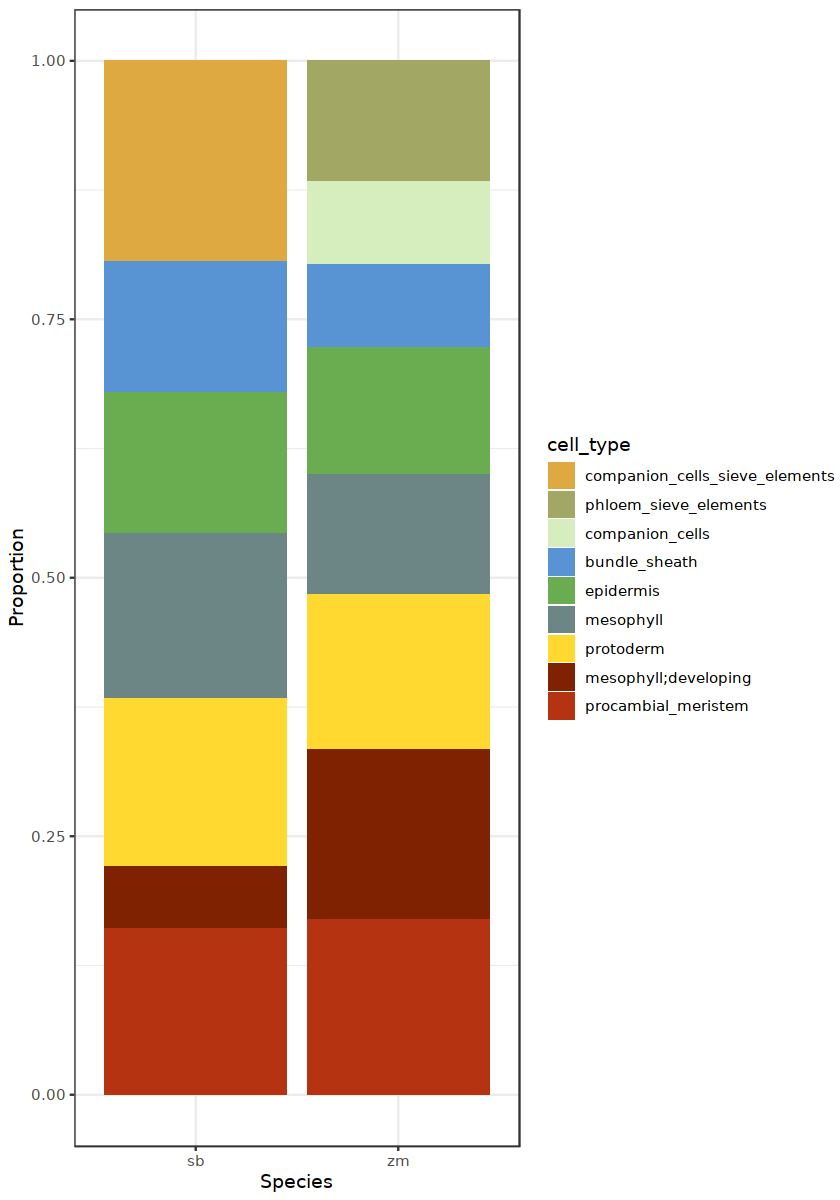

In [12]:


#cell_type_order <- 
options(repr.plot.width=7, repr.plot.height=10)
# Stacked + percent
prop_ct_acrs_by_ct <- combined_acrs  %>% 
    dplyr::filter(is.na(cell_type) != TRUE)  %>%  
    mutate_at(vars(cell_type), 
            list(factor))  %>% 
    mutate(cell_type = forcats::fct_relevel(cell_type, factor_order)) %>%

    ggplot(., aes(fill=cell_type, y=acr_number, x=species)) + 
        geom_bar(position="fill", stat="identity") + xlab("Species") + ylab("Proportion") +
        theme(text = element_text(size = 20)) + theme_bw()

prop_ct_acrs_by_ct + scale_fill_manual(values = colors_large)


In [13]:
# Create the factor_order array
updated_factors <- c("broadly accessible",
                     "cell type restricted",
                  'companion cells/sieve elements',
                  'bundle sheath',
                  'mesophyll developing',
                  'epidermis',
                  'mesophyll',
                  'procambial meristem',
                  'protoderm')

# Create a named vector of colors
cell_type_factor_colors <- c("#DEA940","#A2A763","#D6EEBE","#5894D4","#6AAD51","#6C8686","#FFD92F", "#7f2201","#b53310",
                         "#E7673B","#FB9A99","#E31A1C","#FDBF6F","#CAB2D6","#386CB0","#FFFFB3", "#5dead5","#c11577",
                         "#CCCCCC", "#7570B3","#B15928", "#6A3D9A", "#d87c6a", "#0060e8", "#84c5ff", "#ffd460", "#d81397")
names(cell_type_factor_colors) <- updated_factors


In [14]:
bed_col_names <- c("chrom", "start", "stop", "acr_name_type", "pval")

sb_all_acrs <- read_delim("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/replicate_analysis_one_off/sb/Sb.final_acr_classification.no_exons.all_ACRs.classified.bed", delim = "\t", col_names = bed_col_names) %>% 
    mutate(species = "Sorghum bicolor")  %>% 
    separate(acr_name_type, c("acr_id", "cell_type"), sep = ";")  %>% 
    rowwise()  %>% 
    mutate(cell_type = if_else(str_detect(cell_type, ","), "cell_type_restricted", cell_type))  %>% 
    mutate(cell_type = str_remove(cell_type, "_n_cell_.*"))

zm_all_acrs <- read_delim("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/replicate_analysis_one_off/zm/Zm.final_acr_classification.no_exons.final.all_ACRs.classified.bed", delim = "\t", col_names = bed_col_names)  %>% 
    mutate(species = "Zea mays")  %>% 
    separate(acr_name_type, c("acr_id", "cell_type"), sep = ";")  %>% 
    rowwise()  %>% 
    mutate(cell_type = if_else(str_detect(cell_type, ","), "cell_type_restricted", cell_type))  %>% 
    mutate(cell_type = str_remove(cell_type, "_n_cell_.*"))




combined_species <- bind_rows(sb_all_acrs, zm_all_acrs)  %>% 
    group_by(cell_type, species)  %>% 
    summarise(counts = n())

combined_species

Rows: 65788 Columns: 5
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): chrom, acr_name_type, pval
dbl (2): start, stop

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 55543 Columns: 5
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): chrom, acr_name_type, pval
dbl (2): start, stop

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'cell_type'. You can override using the `.groups` argument.


cell_type                      species         counts
1  broadly_accessible             Sorghum bicolor 42772 
2  broadly_accessible             Zea mays        39757 
3  bundle_sheath                  Sorghum bicolor  1444 
4  bundle_sheath                  Zea mays          721 
5  cell_type_restricted           Sorghum bicolor 10200 
6  cell_type_restricted           Zea mays         6934 
7  companion_cells                Zea mays          709 
8  companion_cells_sieve_elements Sorghum bicolor  2183 
9  epidermis                      Sorghum bicolor  1538 
10 epidermis                      Zea mays         1090 
11 mesophyll                      Sorghum bicolor  1813 
12 mesophyll                      Zea mays         1025 
13 mesophyll_desc_developing      Sorghum bicolor   690 
14 mesophyll_desc_developing      Zea mays         1463 
15 phloem_sieve_elements          Zea mays         1026 
16 procambial_meristem            Sorghum bicolor  1817 
17 procambial_meristem            Zea mays         1503 
18 protoderm                      Sorghum bicolor  1822 
19 protoderm                      Zea mays         1315 
20 unknown_desc_1                 Sorghum bicolor  1509

In [15]:
combined_species  %>% 
    group_by(species)  %>% 
    summarise(nacrs = sum(counts))

species         nacrs
1 Sorghum bicolor 65788
2 Zea mays        55543

In [16]:
total_broadly_accessible_cell_type_specific <- combined_species  %>% 
    dplyr::filter(cell_type != "unknown_desc_1")  %>% 
    mutate(cell_type = case_when(cell_type == "phloem_sieve_elements" ~ "companion_cells/sieve_elements",
                                cell_type == "companion_cells" ~ "companion_cells/sieve_elements",
                                cell_type == "companion_cells_sieve_elements" ~ "companion_cells/sieve_elements", 
                                cell_type == "mesophyll_desc_developing" ~ "mesophyll developing",
                                TRUE ~ cell_type))  %>% 
    dplyr::filter(is.na(cell_type) != TRUE)  %>%  
    mutate(cell_type = str_replace_all(cell_type, "_", " "))  %>% 
    mutate_at(vars(cell_type), 
            list(factor))  %>% 
    mutate(cell_type = forcats::fct_relevel(cell_type, updated_factors))

total_broadly_accessible_cell_type_specific$cell_type

[1] broadly accessible             broadly accessible            
 [3] bundle sheath                  bundle sheath                 
 [5] cell type restricted           cell type restricted          
 [7] companion cells/sieve elements companion cells/sieve elements
 [9] epidermis                      epidermis                     
[11] mesophyll                      mesophyll                     
[13] mesophyll developing           mesophyll developing          
[15] companion cells/sieve elements procambial meristem           
[17] procambial meristem            protoderm                     
[19] protoderm                     
9 Levels: broadly accessible ... protoderm

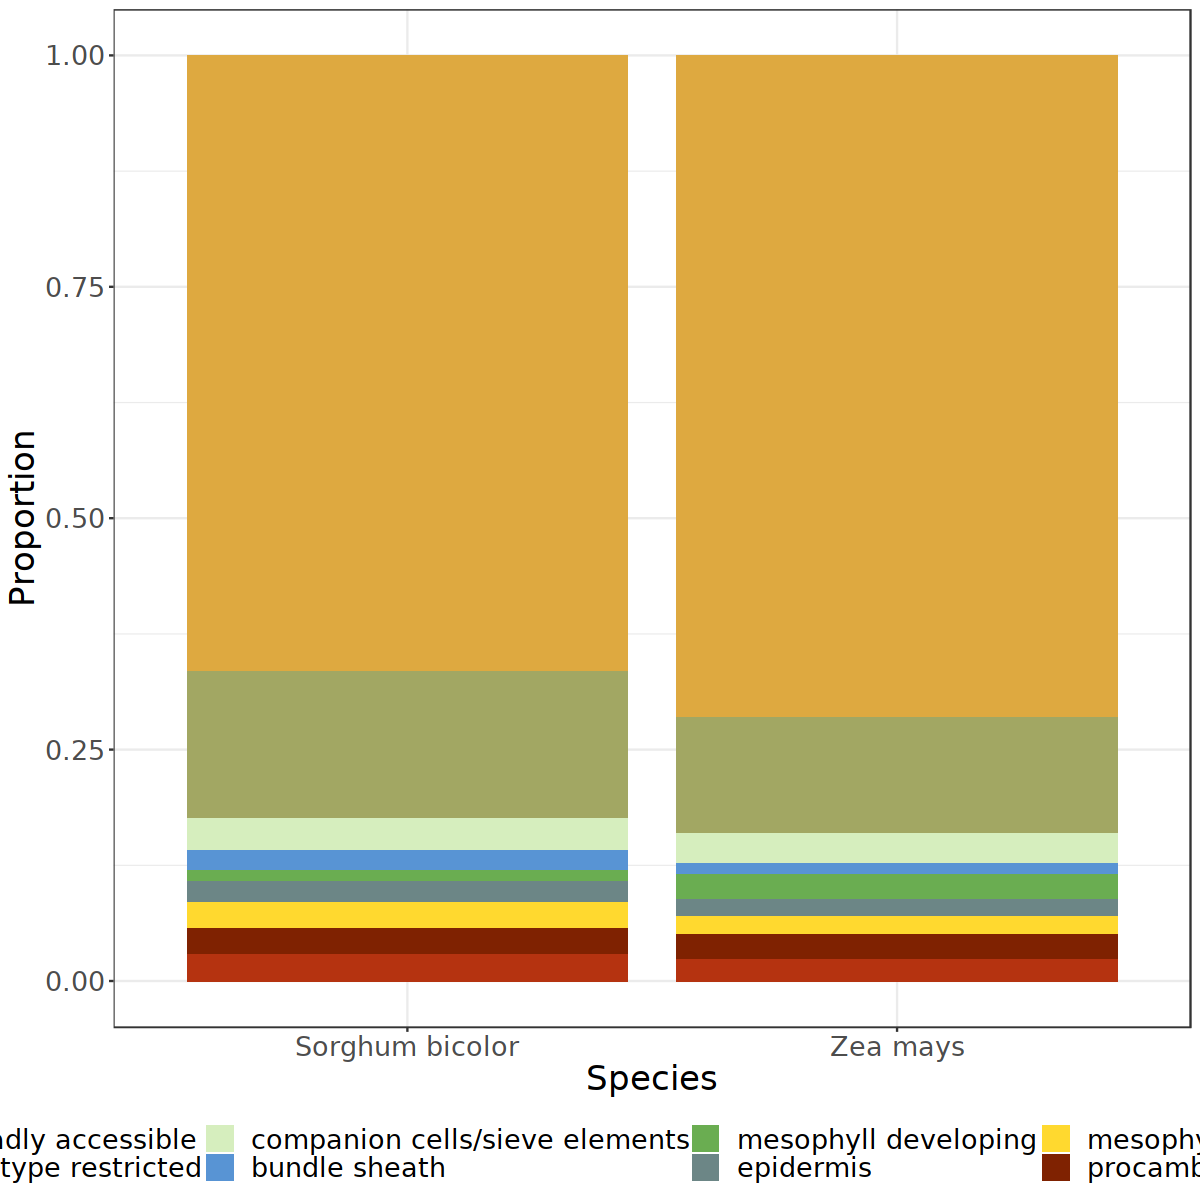

In [20]:
## Updated plot for graphing 
options(repr.plot.width=10, repr.plot.height=10)
# Stacked + percent
total_broadly_accessible_cell_type_specific <- combined_species  %>% 
    dplyr::filter(cell_type != "unknown_desc_1")  %>% 
    mutate(cell_type = case_when(cell_type == "phloem_sieve_elements" ~ "companion_cells/sieve_elements",
                                cell_type == "companion_cells" ~ "companion_cells/sieve_elements",
                                cell_type == "companion_cells_sieve_elements" ~ "companion_cells/sieve_elements", 
                                cell_type == "mesophyll_desc_developing" ~ "mesophyll developing",
                                TRUE ~ cell_type))  %>% 
    dplyr::filter(is.na(cell_type) != TRUE)  %>%  
    mutate(cell_type = str_replace_all(cell_type, "_", " "))  %>% 
    mutate_at(vars(cell_type), 
            list(factor))  %>% 
    mutate(cell_type = forcats::fct_relevel(cell_type, updated_factors)) %>%
    ggplot(., aes(fill=cell_type, y=counts, x=species)) + 
        theme_bw() + 
        geom_bar(position="fill", stat="identity") + xlab("Species") + ylab("Proportion") +
        theme(text = element_text(size = 20))


total_broadly_accessible_cell_type_specific + scale_fill_manual(values = cell_type_factor_colors)

Warning message:
“1 unknown level in `f`: broadly accessible”
Warning message:
“1 unknown level in `f`: broadly accessible”
Warning message:
“1 unknown level in `f`: broadly accessible”
Warning message:
“1 unknown level in `f`: broadly accessible”
Warning message:
“1 unknown level in `f`: broadly accessible”
Warning message:
“1 unknown level in `f`: broadly accessible”
Warning message:
“1 unknown level in `f`: broadly accessible”
Warning message:
“1 unknown level in `f`: broadly accessible”


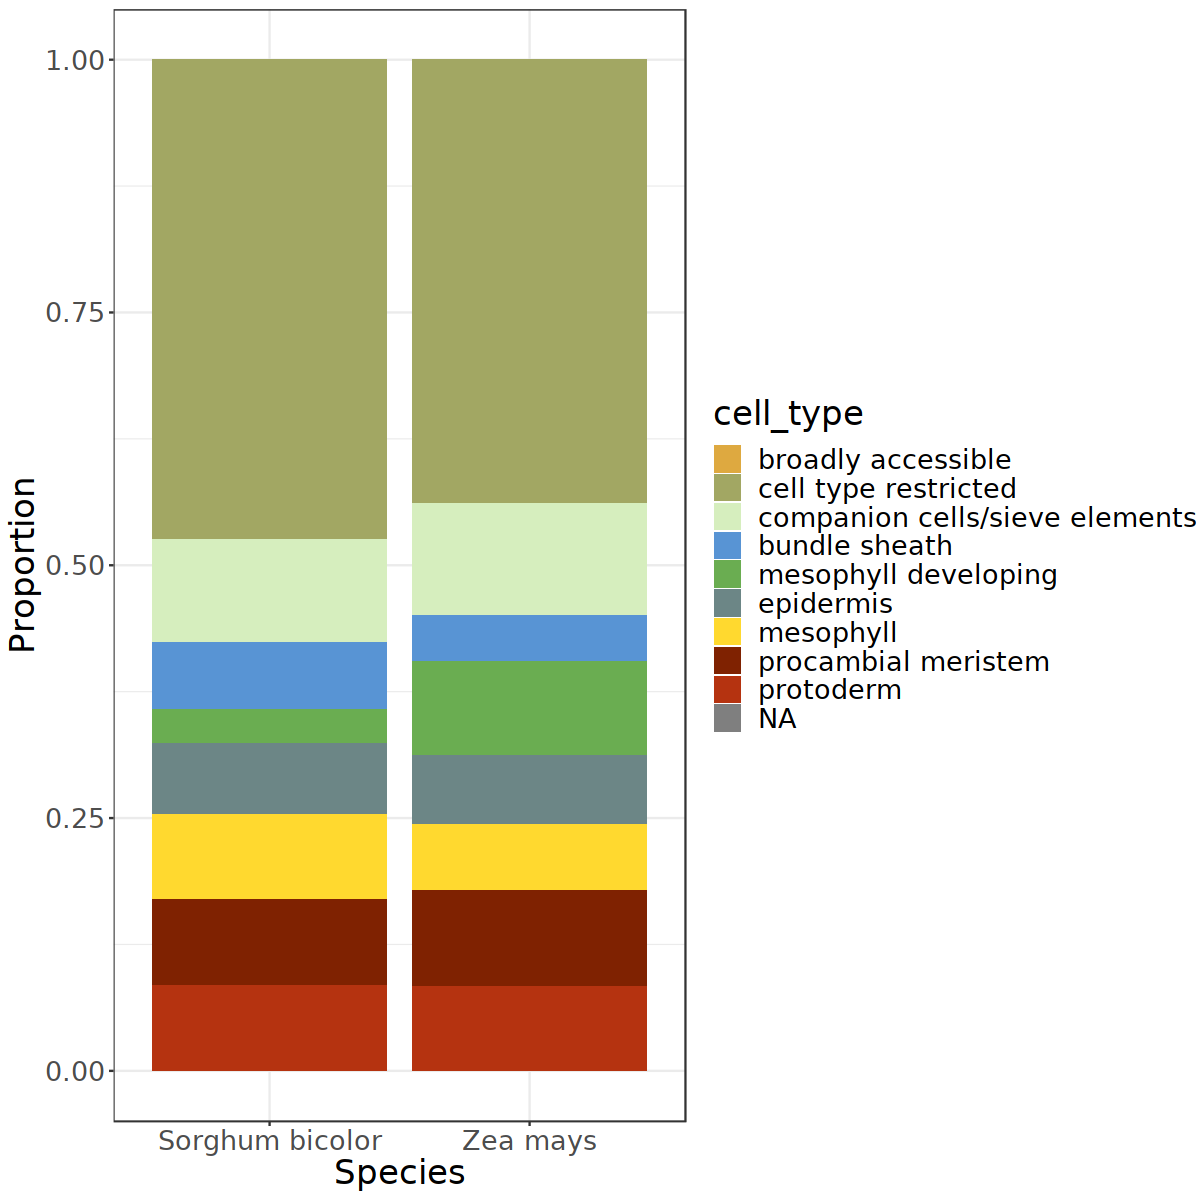

In [18]:
## Updated plot for graphing 
options(repr.plot.width=10, repr.plot.height=10)
# Stacked + percent
cell_type_specific_restricted <- combined_species  %>% 
    dplyr::filter(cell_type != "unknown_desc_1")  %>% 
    dplyr::filter(cell_type != "broadly_accessible")  %>% 
    mutate(cell_type = case_when(cell_type == "phloem_sieve_elements" ~ "companion_cells/sieve_elements",
                                cell_type == "companion_cells" ~ "companion_cells/sieve_elements",
                                cell_type == "companion_cells_sieve_elements" ~ "companion_cells/sieve_elements",
                                cell_type == "mesophyll_desc_developing" ~ "mesophyll developing",
                                TRUE ~ cell_type))  %>% 
    dplyr::filter(is.na(cell_type) != TRUE)  %>%  
    mutate(cell_type = str_replace_all(cell_type, "_", " "))  %>% 
    mutate_at(vars(cell_type), 
            list(factor))  %>% 
    mutate(cell_type = forcats::fct_relevel(cell_type, updated_factors)) %>%
    ggplot(., aes(fill=cell_type, y=counts, x=species)) + 
        theme_bw() + 
        geom_bar(position="fill", stat="identity") + xlab("Species") + ylab("Proportion") +
        theme(text = element_text(size = 20)) 



cell_type_specific_restricted + scale_fill_manual(values = cell_type_factor_colors)

Warning message:
“2 unknown levels in `f`: broadly accessible and cell type restricted”
Warning message:
“2 unknown levels in `f`: broadly accessible and cell type restricted”
Warning message:
“2 unknown levels in `f`: broadly accessible and cell type restricted”
Warning message:
“2 unknown levels in `f`: broadly accessible and cell type restricted”
Warning message:
“2 unknown levels in `f`: broadly accessible and cell type restricted”
Warning message:
“2 unknown levels in `f`: broadly accessible and cell type restricted”
Warning message:
“2 unknown levels in `f`: broadly accessible and cell type restricted”


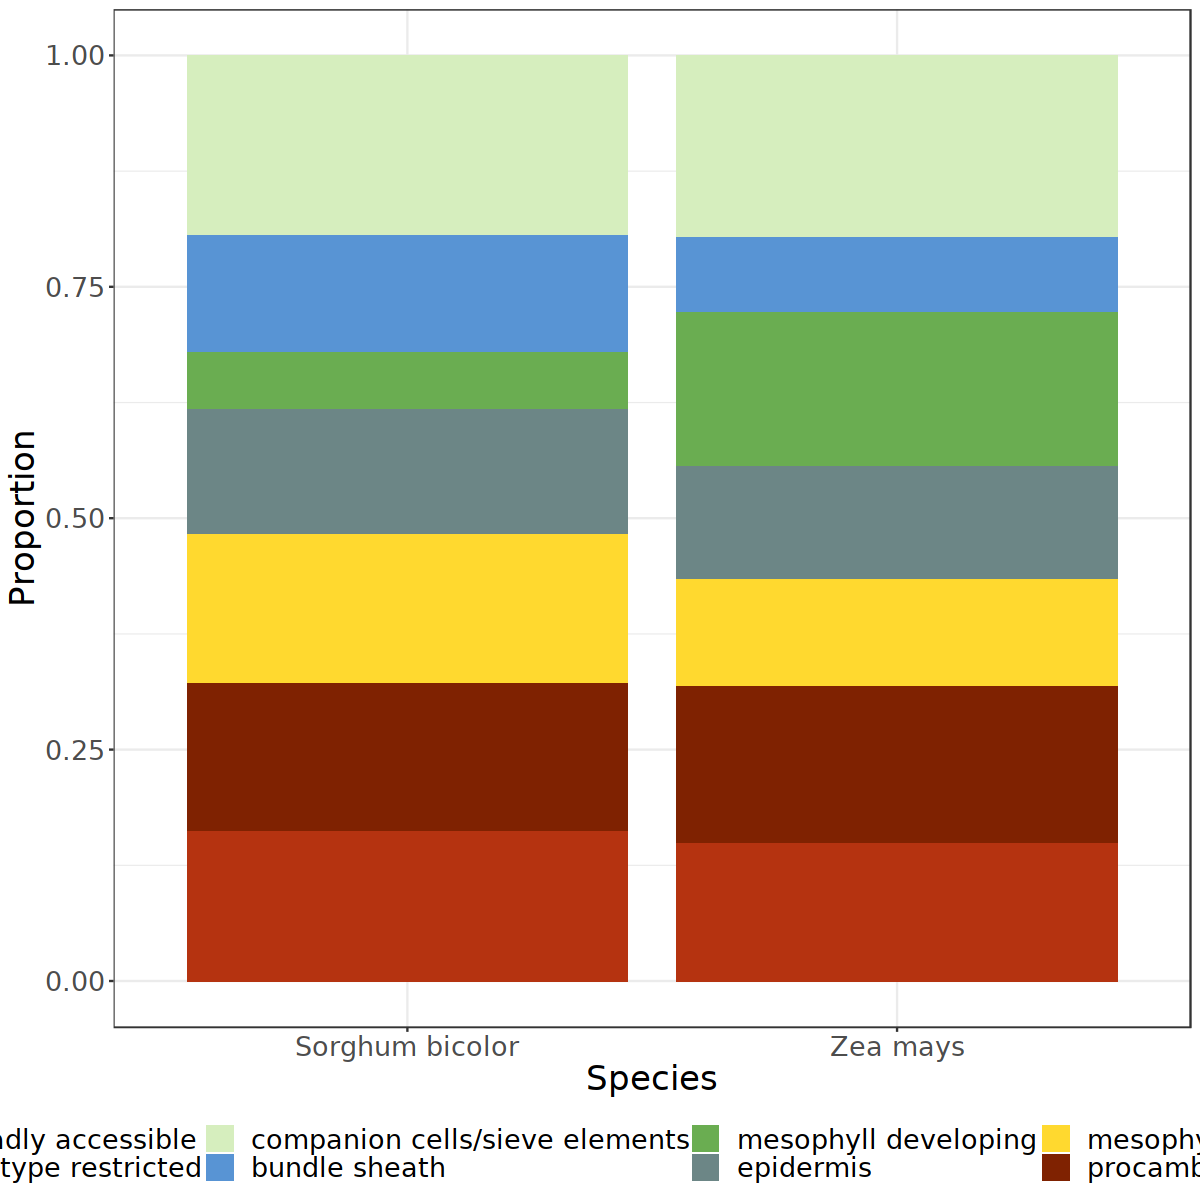

In [19]:
## Updated plot for graphing 
options(repr.plot.width=10, repr.plot.height=10)
# Stacked + percent
cell_type_specific <- combined_species  %>% 
    dplyr::filter(cell_type != "unknown_desc_1")  %>% 
    dplyr::filter(cell_type != "broadly_accessible")  %>% 
    dplyr::filter(cell_type != "cell_type_restricted")  %>% 
    mutate(cell_type = case_when(cell_type == "phloem_sieve_elements" ~ "companion_cells/sieve_elements",
                                cell_type == "companion_cells" ~ "companion_cells/sieve_elements",
                                cell_type == "companion_cells_sieve_elements" ~ "companion_cells/sieve_elements",
                                cell_type == "mesophyll_desc_developing" ~ "mesophyll developing",
                                TRUE ~ cell_type))  %>% 
    dplyr::filter(is.na(cell_type) != TRUE)  %>%  
    mutate(cell_type = str_replace_all(cell_type, "_", " "))  %>% 
    mutate_at(vars(cell_type), 
            list(factor))  %>% 
    mutate(cell_type = forcats::fct_relevel(cell_type, updated_factors)) %>%
    ggplot(., aes(fill=cell_type, y=counts, x=species)) + 
        theme_bw() + 
        geom_bar(position="fill", stat="identity") + xlab("Species") + ylab("Proportion") +
        theme(text = element_text(size = 20))    



cell_type_specific + scale_fill_manual(values = cell_type_factor_colors)

In [19]:
zm_Frip <- zm_metadata  %>% 
    ggplot(., aes(x = final_annotation, y = FRiP)) + geom_violin() +
    theme(text = element_text(size = 20)) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))  + 
  stat_summary(fun.data = "mean_cl_boot", geom = "pointrange",
               colour = "red")

zm_total <- zm_metadata  %>% 
    ggplot(., aes(x = final_annotation, y = log(total))) + geom_violin() +
    theme(text = element_text(size = 20)) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
  stat_summary(fun.data = "mean_cl_boot", geom = "pointrange",
               colour = "red")


zm_ptmt <- zm_metadata  %>% 
    dplyr::filter(final_annotation != "ground_meristem")  %>% 
    ggplot(., aes(x = final_annotation, y = acrs)) + geom_violin() +
    theme(text = element_text(size = 20)) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
  stat_summary(fun.data = "mean_cl_boot", geom = "pointrange",
               colour = "red")


 

In [20]:
zm_metadata  %>% 
    group_by(final_annotation)  %>% 
    summarise(total_reads = sum(total))

final_annotation      total_reads
1 bundle_sheath         11315291   
2 companion_cells        2270150   
3 epidermis             11858882   
4 mesophyll             13962760   
5 mesophyll;developing   1607061   
6 phloem_sieve_elements  4400031   
7 procambial_meristem    1106012   
8 protoderm              8172694

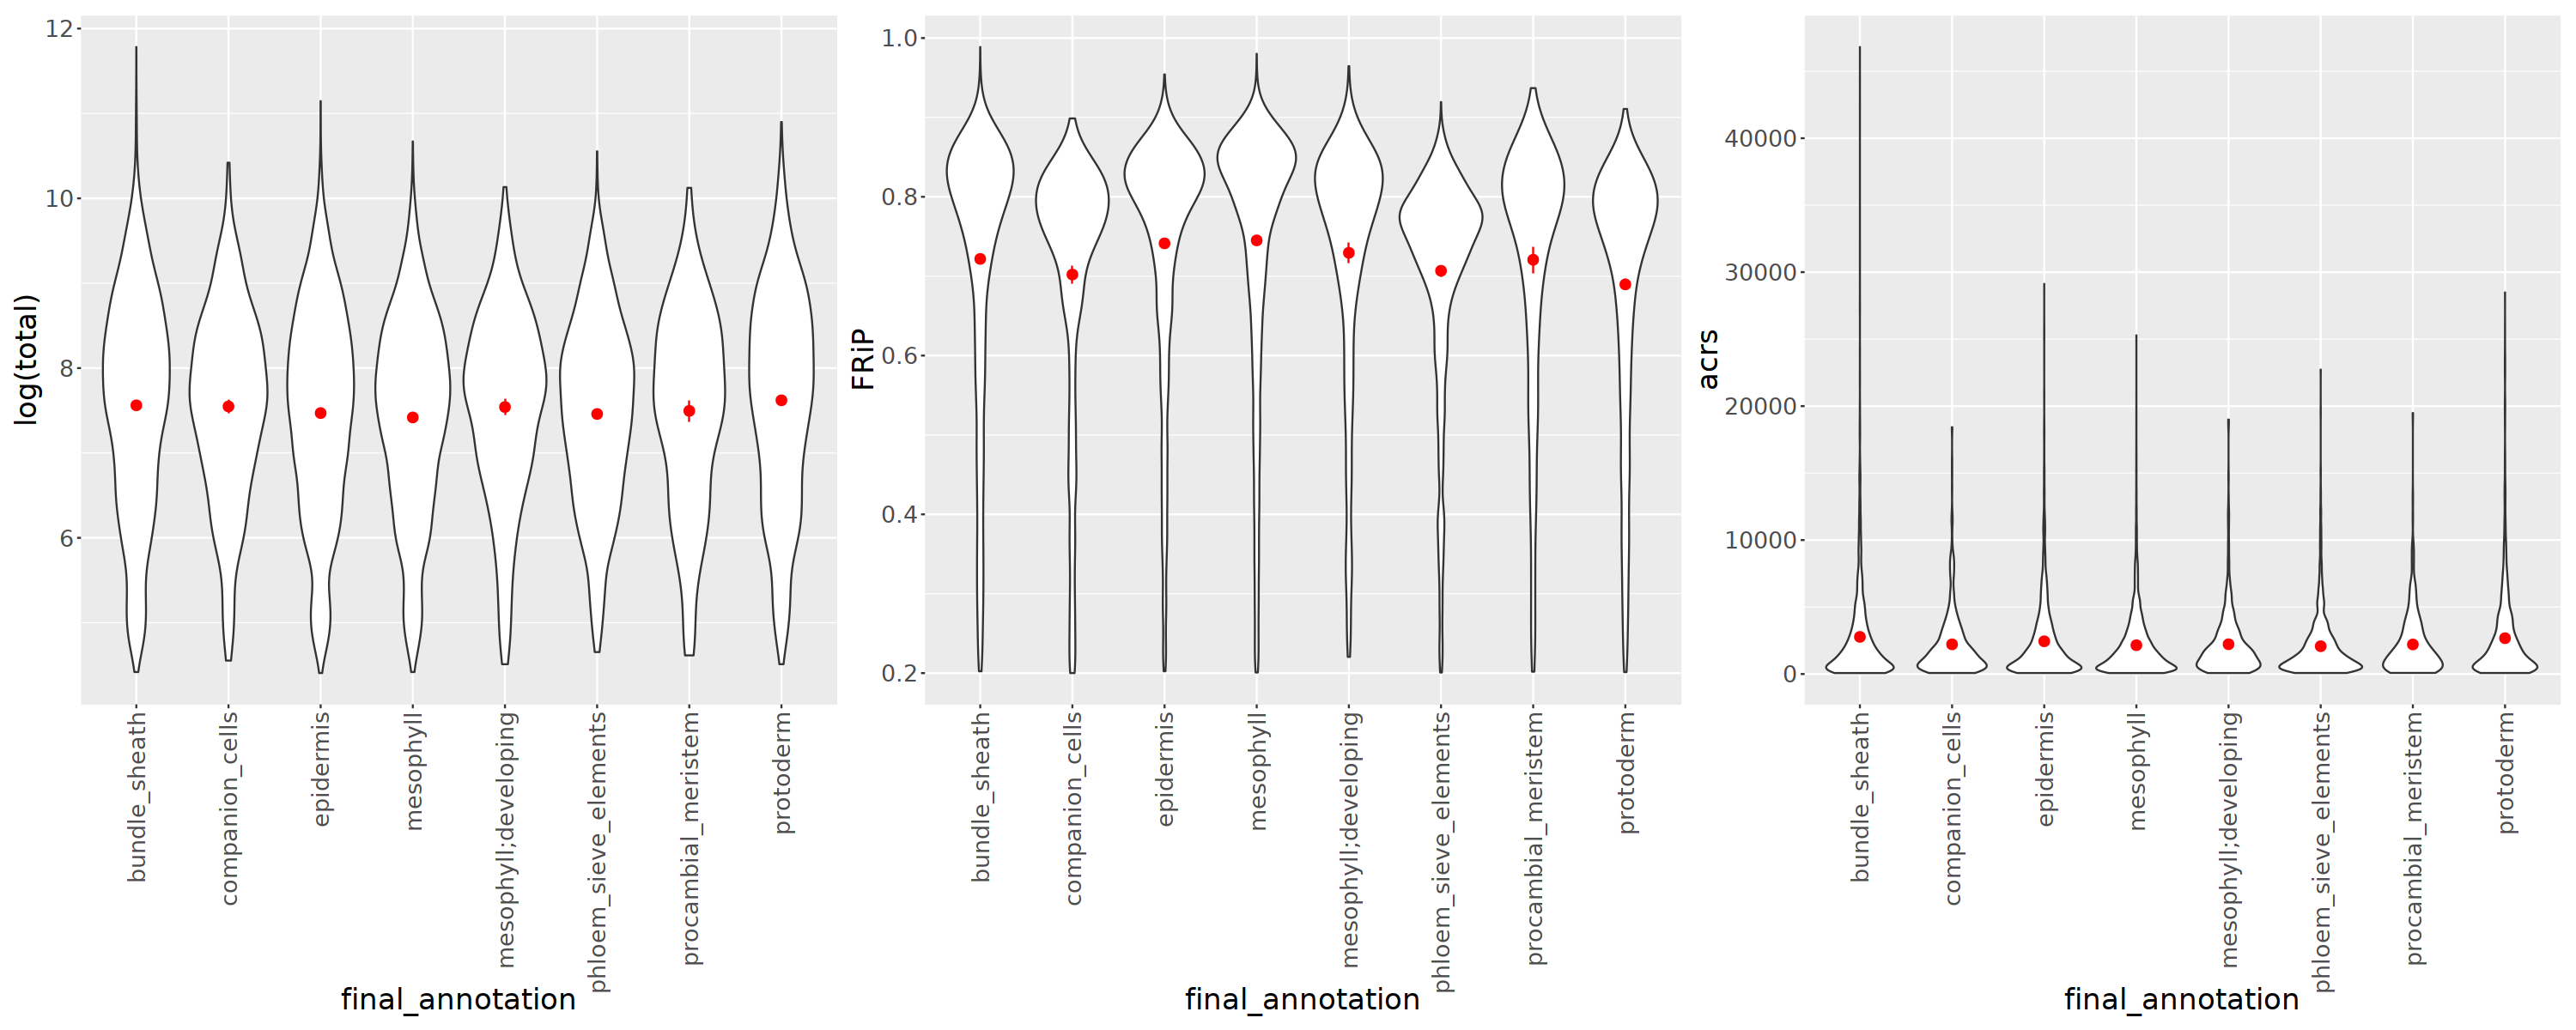

In [21]:
library(patchwork)

options(repr.plot.width=25, repr.plot.height=10)
zm_total + zm_Frip + zm_ptmt

Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message in max(data$density):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Computation failed in `stat_ydensity()`:
replacement has 1 row, data has 0”
Warning message:
“Removed 8 rows containing missing values (geom_segment).”


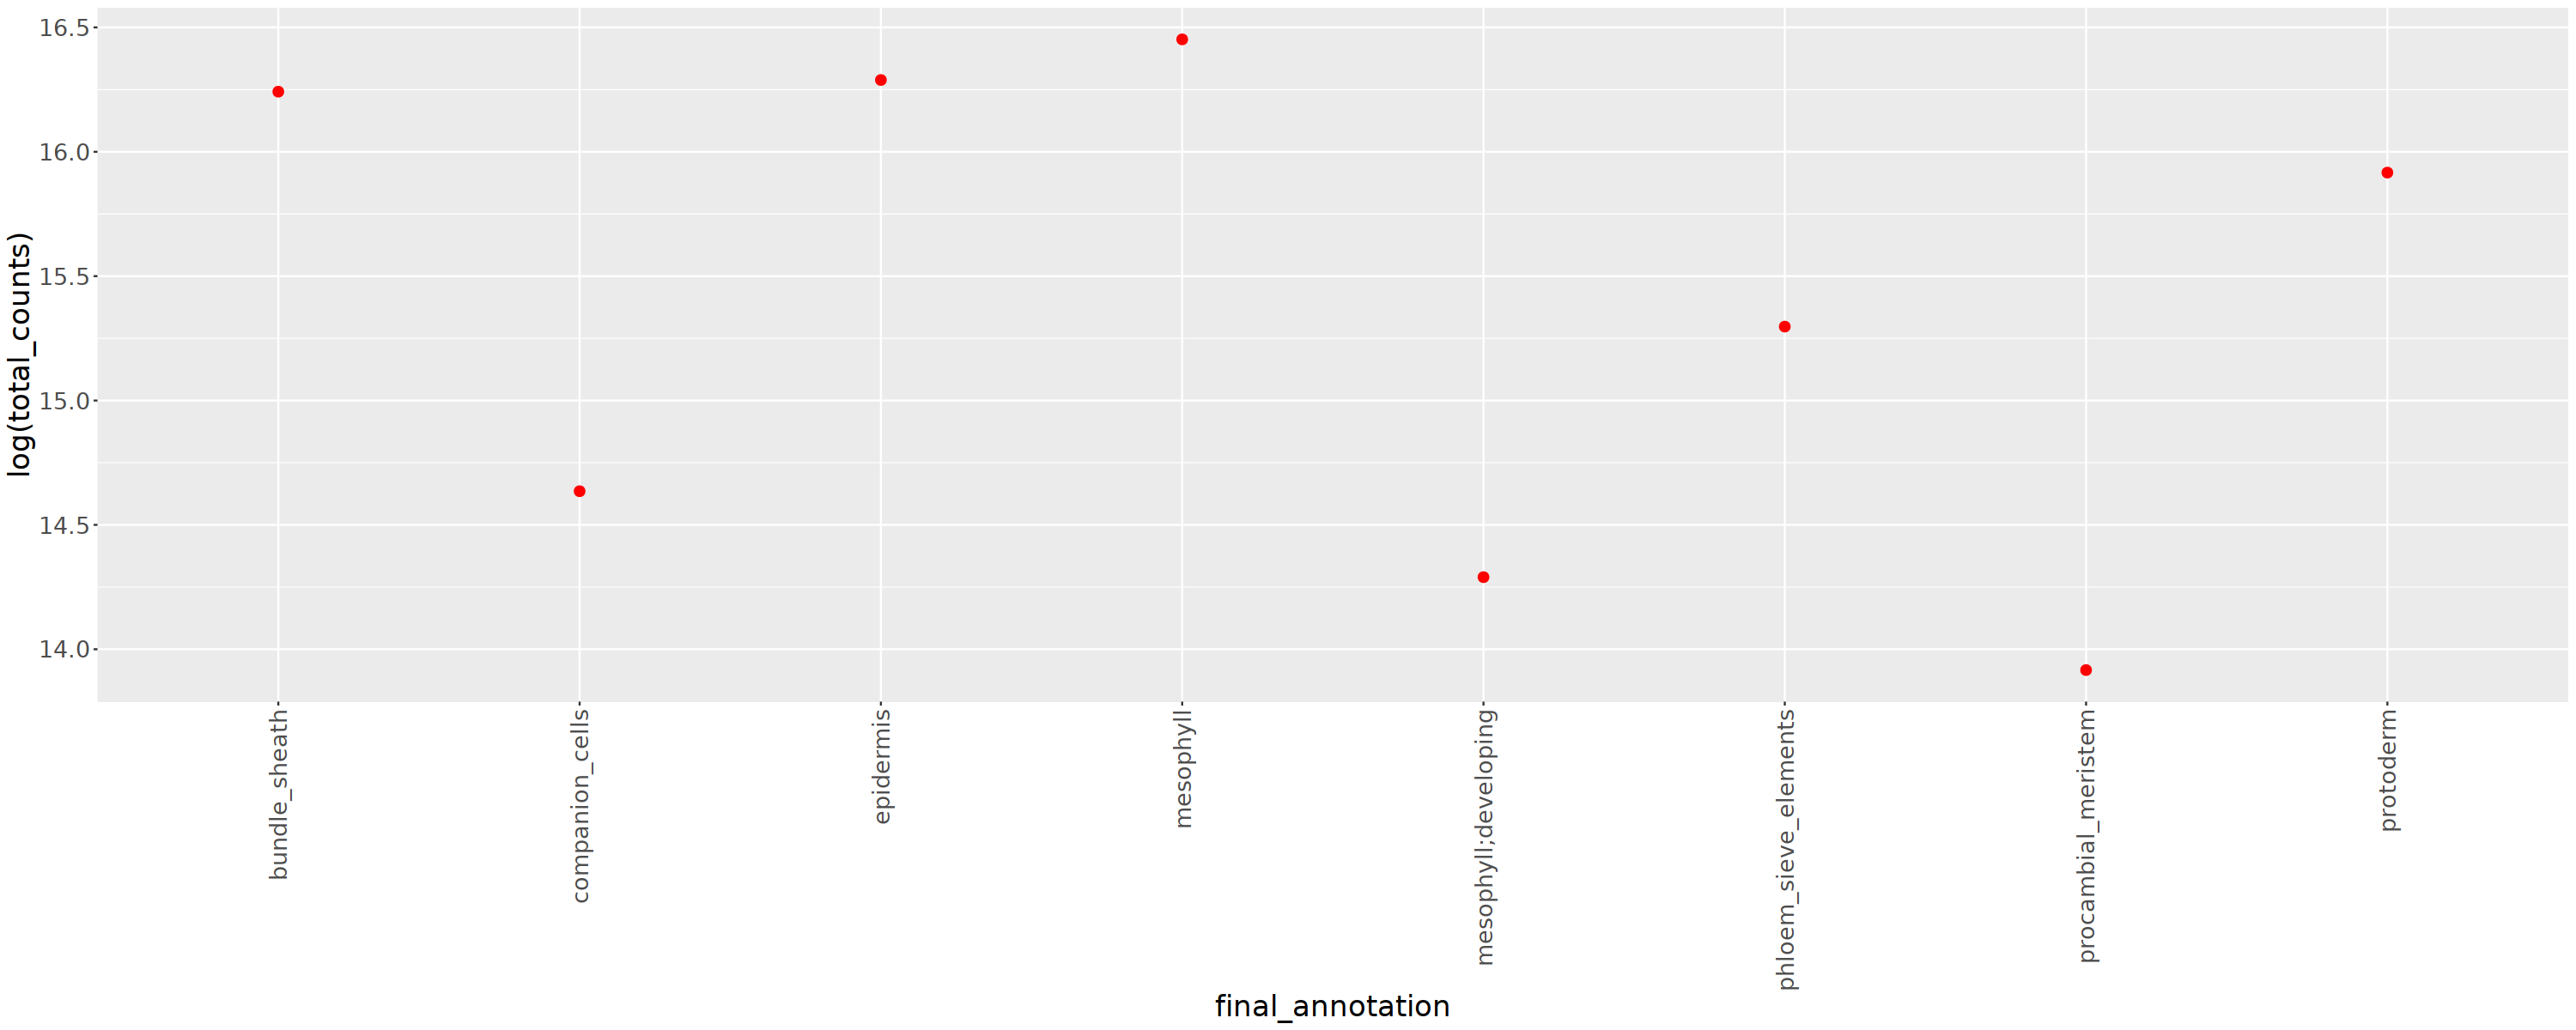

In [22]:
zm_metadata  %>% 
    group_by(final_annotation)  %>% 
    summarise(total_counts = sum(total))  %>% 
    ggplot(., aes(x = final_annotation, y = log(total_counts))) + geom_violin() +
    theme(text = element_text(size = 20)) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
  stat_summary(fun.data = "mean_cl_boot", geom = "pointrange",
               colour = "red")


# Generating Ven_Diagrams for Overlaps

In [24]:
55543 - 14446

[1] 41097

Loading required package: grid

Loading required package: futile.logger


Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


Rows: 1 Columns: 3
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (3): both, CNSs, ACRs

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1 Columns: 3
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (3): both, CNSs, ACRs

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


INFO [2023-03-17 10:03:12] Placing category labels at default outer locations.  Use "cat.pos" and "cat.dist" to modify location.
INFO [2023-03-17 10:03:12] Current "cat.pos": 0 degrees, 0 degrees
INFO [2023-03-17 10:03:12] Current "cat.dist": 0.08 , 0.08
INFO [2023-03-17 10:03:13] Placing category labels at default outer locations.  Use "cat.pos" and "cat.dist" to modify location.
INFO [2023-03-17 10:03:13] Current "cat.pos": 0 degrees, 0 degrees
INFO [2023-03-17 10:03:13] Current "cat.dist": 0.08 , 0.08


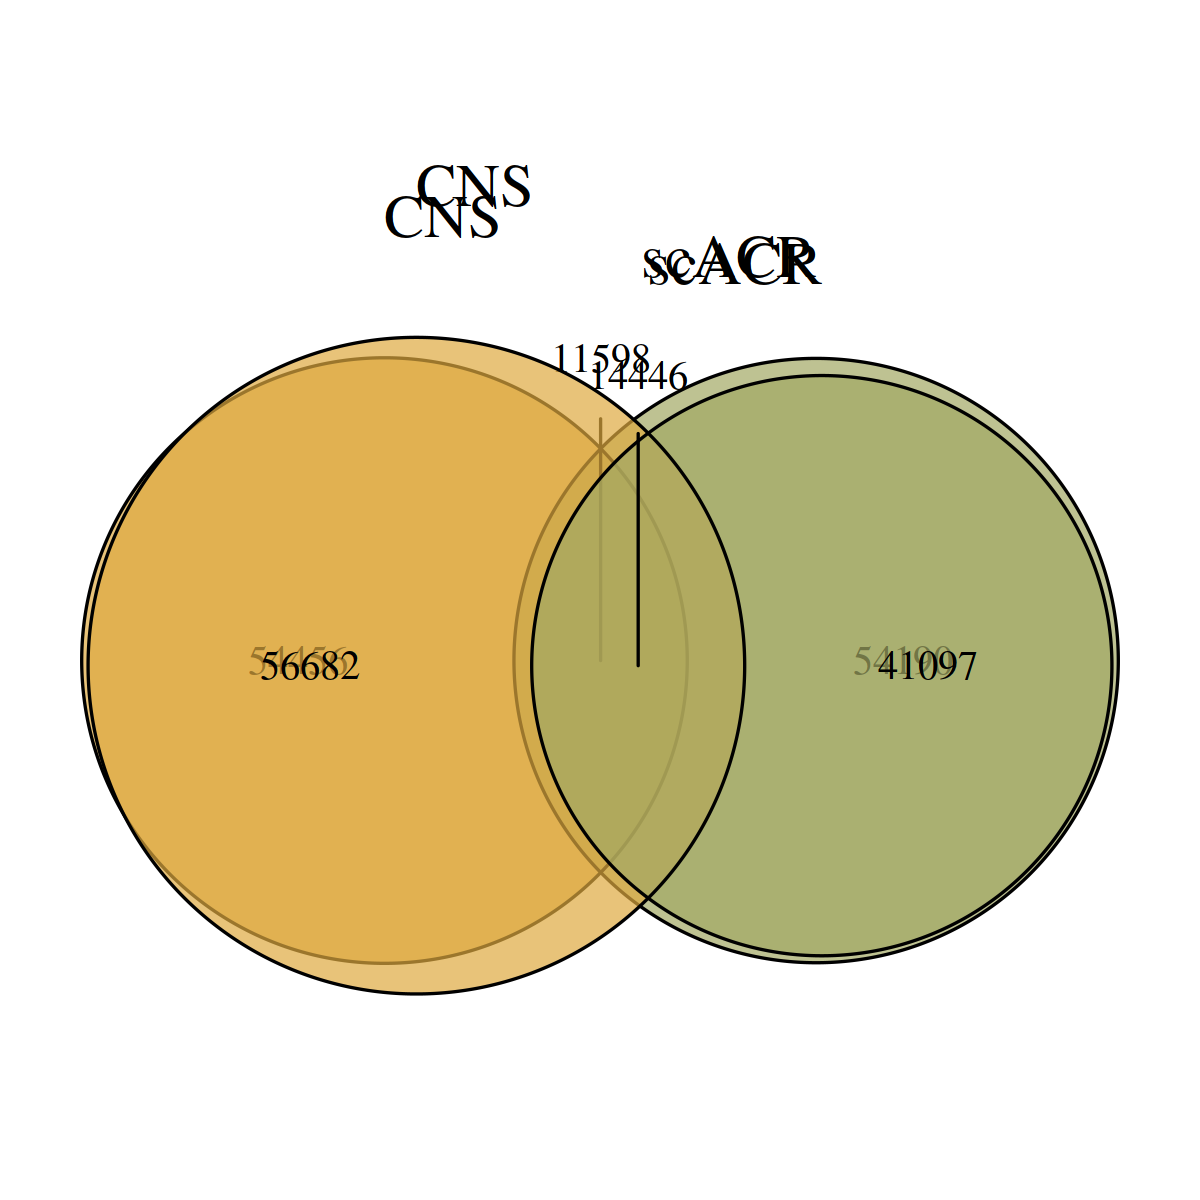

In [25]:
library(VennDiagram)
library(cowplot)

read_in_vals <- function(file_name){


  hist_mod_file <- readr::read_delim(file_name,'\t', col_names = TRUE)

  return(hist_mod_file)

}


sb_CNS_scACR_overlaps <- read_in_vals("/scratch/jpm73279/comparative_single_cell/17.analyze_cell_type_ACRs/Sb.CNS_ACR.counts.V5.txt")
zm_CNS_scACR_overlaps <- read_in_vals("/scratch/jpm73279/comparative_single_cell/17.analyze_cell_type_ACRs/Zm.CNS_ACR.counts.V5.txt")



sb_scACR_CNS_overlap <- draw.pairwise.venn(
    area1 = sb_CNS_scACR_overlaps$CNSs,
    area2 = sb_CNS_scACR_overlaps$ACRs,
    cross.area = sb_CNS_scACR_overlaps$both,
    ext.line.lty = "solid",
    fill = colors_large[1:2],
    category = c("CNS","scACR"),
    #fill = c(H3K36me3_colors, H3K4me1_colors),
    alpha = c(0.7, 0.7),
    scale = TRUE,
    ind = TRUE,
    cex = 2, #Size of the values in the diagram
    cat.cex = 3, #Size of the Titles


    #THE BELOW TWO LINES FLIP THE TEXT AND THE ORDER
    cat.pos = c(0, 0),

    cat.dist = c(0.08, 0.08),
    cat.just = list(c(0, 0), c(1, 1)),
    cat.prompts = TRUE,
    margin = 0.05,
    ext.text = TRUE, #If small as area, place labe outside
    ext.percent = .4, #If small as area, place labe outside
    ext.dist = -.2,
    ext.length = 0.8,
    ext.line.lwd = 2,
    ext.pos = c(0,0))


sb_scACR_CNS_ven <- ggdraw(sb_scACR_CNS_overlap) + theme(plot.background = element_rect(fill = NA),plot.margin = margin(12, 12, 12, 12))

zm_scACR_CNS_overlap <- draw.pairwise.venn(
    area1 = zm_CNS_scACR_overlaps$CNSs,
    area2 = zm_CNS_scACR_overlaps$ACRs,
    cross.area = zm_CNS_scACR_overlaps$both,
    ext.line.lty = "solid",
    fill = colors_large[1:2],
    category = c("CNS","scACR"),
    #fill = c(H3K36me3_colors, H3K4me1_colors),
    alpha = c(0.7, 0.7),
    scale = TRUE,
    ind = TRUE,
    cex = 2, #Size of the values in the diagram
    cat.cex = 3, #Size of the Titles


    #THE BELOW TWO LINES FLIP THE TEXT AND THE ORDER
    cat.pos = c(0, 0),

    cat.dist = c(0.08, 0.08),
    cat.just = list(c(0, 0), c(1, 1)),
    cat.prompts = TRUE,
    margin = 0.05,
    ext.text = TRUE, #If small as area, place labe outside
    ext.percent = .4, #If small as area, place labe outside
    ext.dist = -.2,
    ext.length = 0.8,
    ext.line.lwd = 2,
    ext.pos = c(0,0))


zm_scACR_CNS_ven <- ggdraw(zm_scACR_CNS_overlap) + theme(plot.background = element_rect(fill = NA),plot.margin = margin(12, 12, 12, 12))



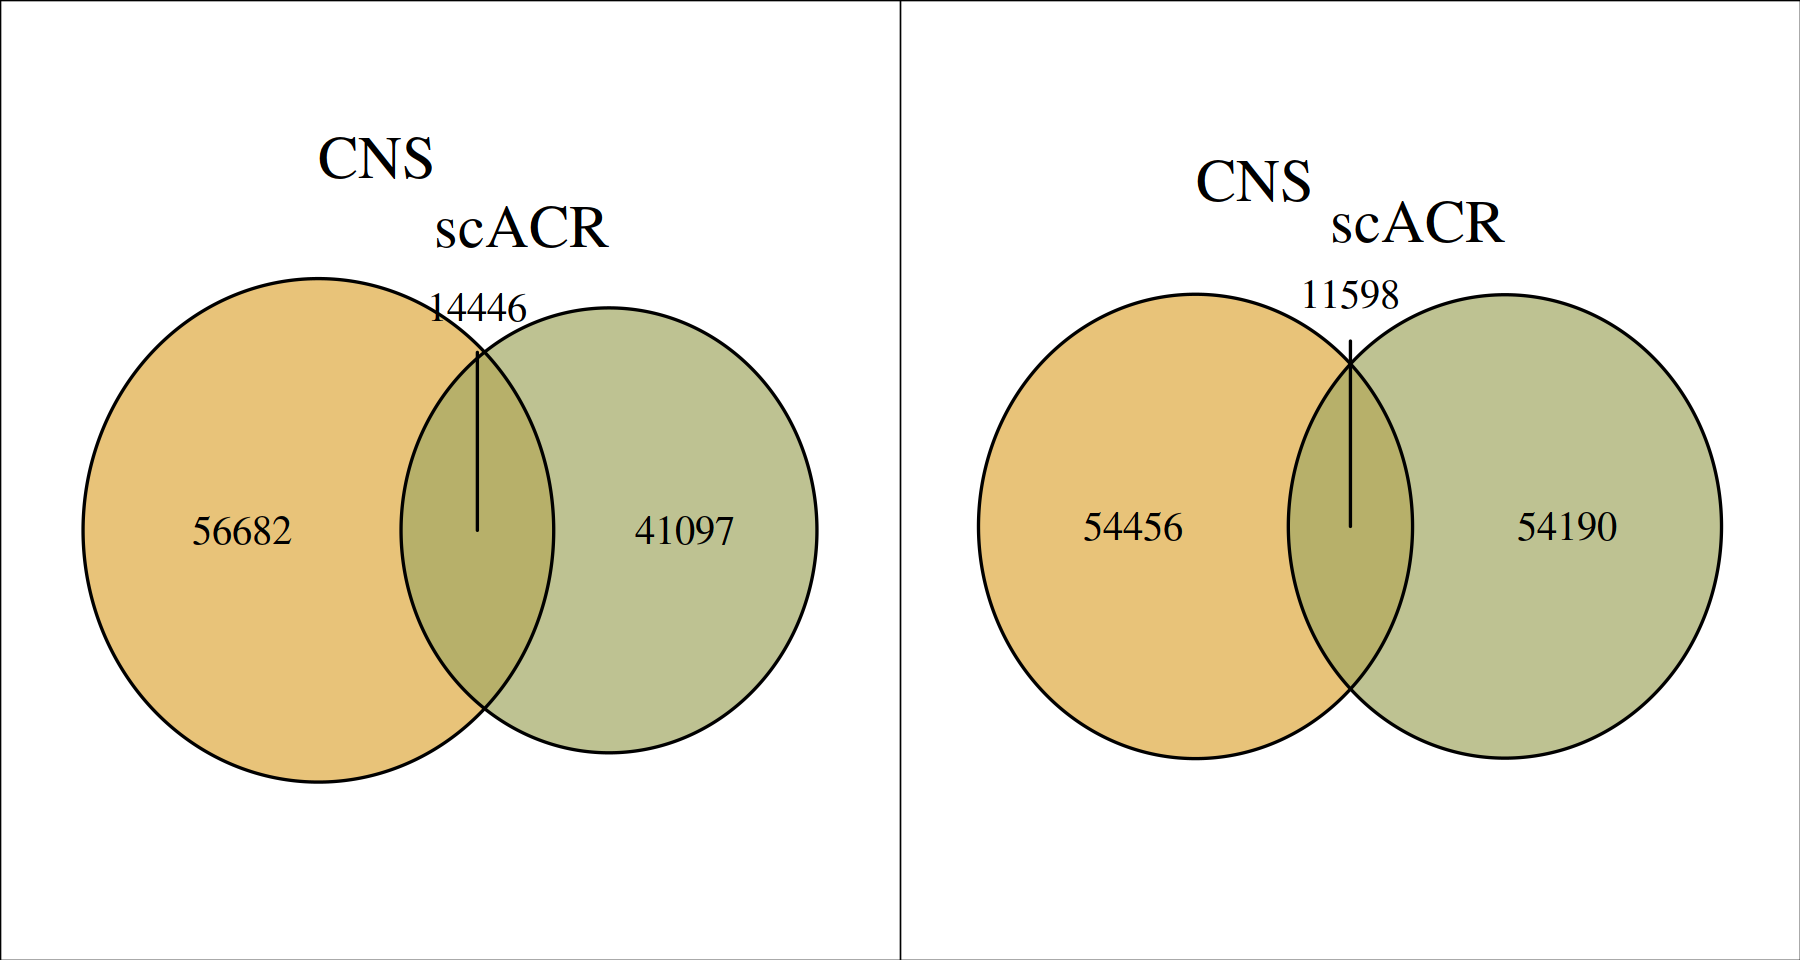

In [26]:
options(repr.plot.width=15, repr.plot.height=8)
plot_grid(zm_scACR_CNS_ven, sb_scACR_CNS_ven)

In [27]:
sb_cols <- c("cns_chrom", "cns_start", "cns_stop", "cns_ID", "acr_chrom", "acr_start", "acr_stop", "acr_id", "acr_acc", "pval", "overlap")
sb_CNS_ACR_overlap <- read_delim("/scratch/jpm73279/comparative_single_cell/17.analyze_cell_type_ACRs/Sb_CNS_ACR_overlap.V5.txt", delim="\t", col_names = sb_cols)  %>% 
    mutate(species = "Sorghum bicolor")
zm_CNS_ACR_overlap <- read_delim("/scratch/jpm73279/comparative_single_cell/17.analyze_cell_type_ACRs/Zm_CNS_ACR_overlap.V5.txt", delim="\t", col_names = sb_cols)  %>% 
    mutate(species = "Zea mays")


Zm_Sb_CNS_ACR_overlaps <- bind_rows(sb_CNS_ACR_overlap, zm_CNS_ACR_overlap)

Rows: 66056 Columns: 10
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): cns_chrom, cns_ID, acr_chrom, acr_id, acr_acc
dbl (5): cns_start, cns_stop, acr_start, acr_stop, pval

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 71129 Columns: 10
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): cns_chrom, cns_ID, acr_chrom, acr_id, acr_acc
dbl (5): cns_start, cns_stop, acr_start, acr_stop, pval

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [28]:
Zm_Sb_CNS_ACR_overlaps.filtered <- Zm_Sb_CNS_ACR_overlaps  %>% 
    dplyr::filter(acr_chrom != ".")  %>% 
    separate(acr_id, c("acr_id", "cell_type"), sep = ";")  %>% 
    rowwise()  %>% 
    mutate(cell_type = if_else(str_detect(cell_type, ","), "cell_type_restricted", cell_type))  %>% 
    mutate(cell_type = str_remove(cell_type, "_n_cell_.*"))




`summarise()` has grouped output by 'species'. You can override using the `.groups` argument.


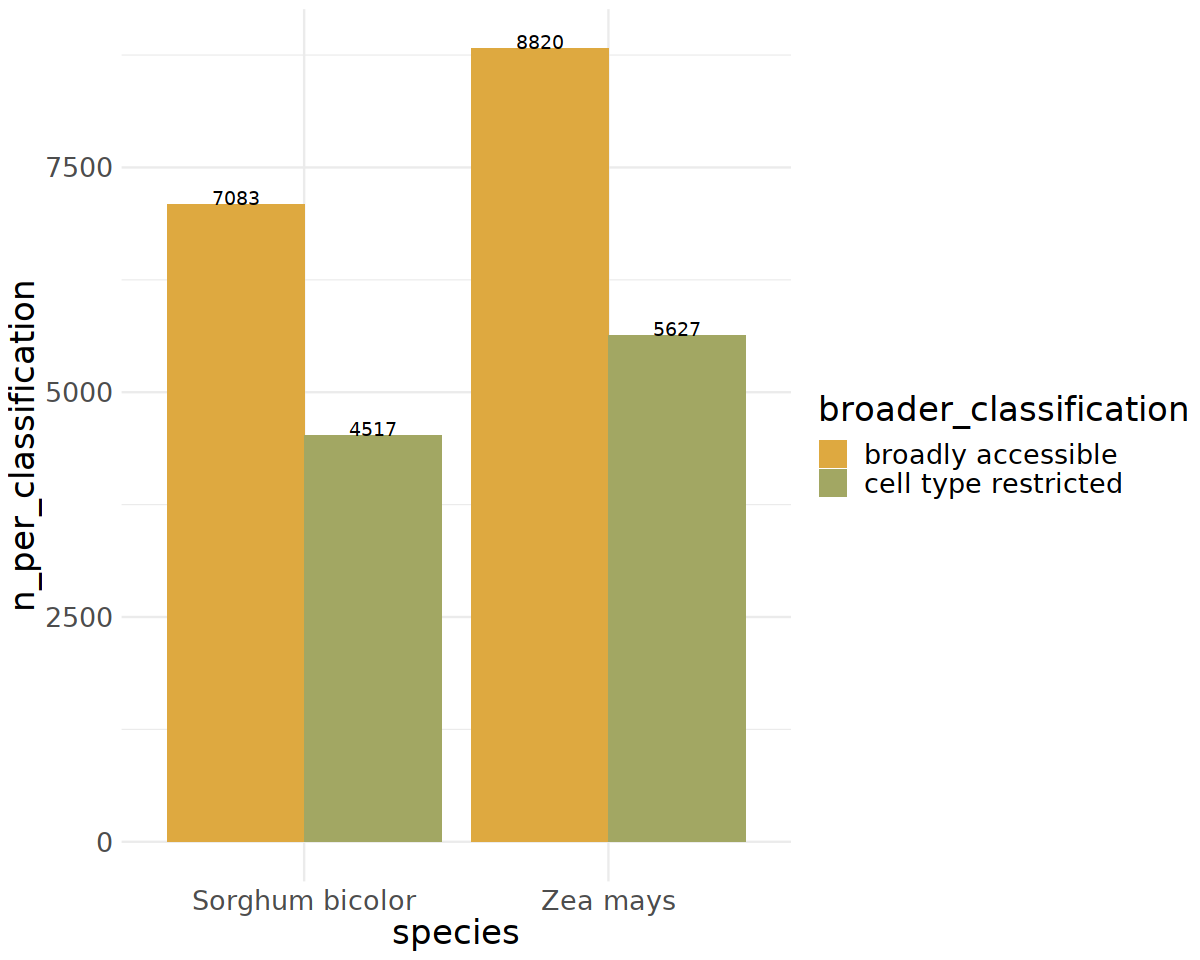

In [29]:

options(repr.plot.width=10, repr.plot.height=8)
Zm_Sb_CNS_ACR_overlaps.filtered  %>% 
    mutate(broader_classification = case_when(cell_type == "broadly_accessible" ~ "broadly accessible", 
                                             TRUE ~ "cell type restricted"))  %>% 
    group_by(species, broader_classification)  %>% 
    summarise(n_per_classification = n()) %>% 
    ggplot(., aes(x = species, y = n_per_classification, fill = broader_classification)) +
        geom_bar(stat="identity", position=position_dodge()) +
    geom_text(aes(label=n_per_classification), vjust=0, color="black",
            position = position_dodge(0.9))+
            scale_fill_manual(values = colors_large) +
            theme_minimal() + theme(text = element_text(size = 20))

`summarise()` has grouped output by 'species'. You can override using the `.groups` argument.


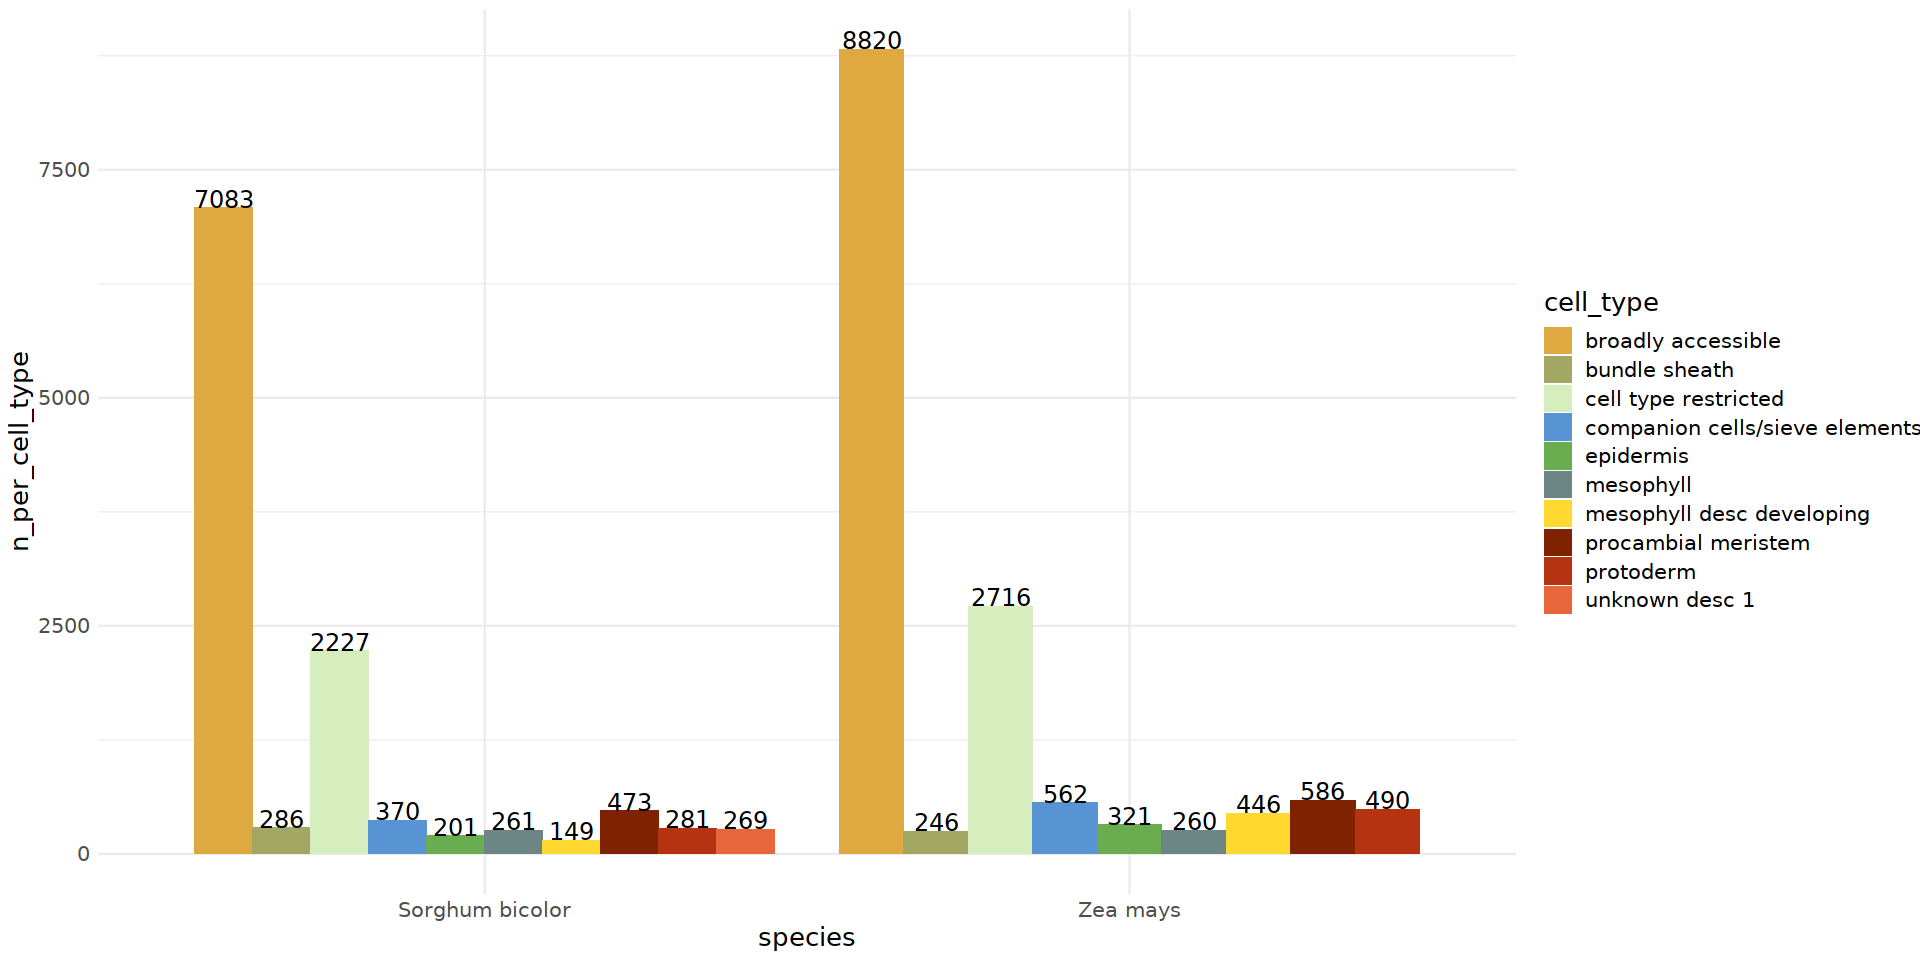

In [30]:

options(repr.plot.width=16, repr.plot.height=8)


Zm_Sb_CNS_ACR_overlaps.filtered  %>% 
    mutate(cell_type = case_when(cell_type == "phloem_sieve_elements" ~ "companion_cells/sieve_elements",
                                cell_type == "companion_cells" ~ "companion_cells/sieve_elements",
                                cell_type == "companion_cells_sieve_elements" ~ "companion_cells/sieve_elements",
                                TRUE ~ cell_type))  %>% 
    group_by(species, cell_type)  %>% 
    summarise(n_per_cell_type = n()) %>% 

    mutate(cell_type = str_replace_all(cell_type, "_", " "))  %>% 
    ggplot(., aes(x = species, y = n_per_cell_type, fill = cell_type)) +
        geom_bar(stat="identity", position=position_dodge()) +
    geom_text(aes(label=n_per_cell_type), vjust=0, color="black",
            position = position_dodge(0.9), size=5) +
            scale_fill_manual(values = colors_large) +
            theme_minimal() + theme(text = element_text(size = 15))


In [31]:
Zm_Sb_CNS_ACR_overlaps.filtered  %>% 
    group_by(species)  %>% 
    summarise(n_per_cell_type = n()) 

species         n_per_cell_type
1 Sorghum bicolor 11600          
2 Zea mays        14447

In [32]:
library(ggsankey)

In [33]:
Zm_Sb_CNS_ACR_overlaps.filtered

cns_chrom cns_start cns_stop  cns_ID    acr_chrom acr_start acr_stop 
1     Chr01       71094     71143   CNS_59    Chr01       70772     71273  
2     Chr01      182446    182499   CNS_61    Chr01      182455    182956  
3     Chr01      182652    182685   CNS_62    Chr01      182455    182956  
4     Chr01      547392    547430   CNS_74    Chr01      547389    547890  
5     Chr01      547497    547536   CNS_75    Chr01      547389    547890  
6     Chr09     2527447   2527467   CNS_91    Chr09     2527359   2527860  
7     Chr09     2527490   2527503   CNS_92    Chr09     2527359   2527860  
8     Chr01      799568    799616   CNS_113   Chr01      799208    799709  
9     Chr01      799696    799727   CNS_114   Chr01      799208    799709  
10    Chr01      948065    948084   CNS_159   Chr01      947833    948334  
11    Chr01      948084    948122   CNS_160   Chr01      947833    948334  
12    Chr01      971095    971127   CNS_169   Chr01      970740    971241  
13    Chr01      971127    971149   CNS_170   Chr01      970740    971241  
14    Chr01     1175068   1175099   CNS_174   Chr01     1174897   1175398  
15    Chr01     1182653   1182679   CNS_191   Chr01     1182229   1182730  
16    Chr01     1183740   1183787   CNS_193   Chr01     1183478   1183979  
17    Chr01     1201083   1201126   CNS_200   Chr01     1201086   1201587  
18    Chr01     1261529   1261578   CNS_232   Chr01     1261437   1261938  
19    Chr01     1261663   1261672   CNS_233   Chr01     1261437   1261938  
20    Chr01     1261672   1261696   CNS_234   Chr01     1261437   1261938  
21    Chr01     1261696   1261726   CNS_235   Chr01     1261437   1261938  
22    Chr01     1261726   1261743   CNS_236   Chr01     1261437   1261938  
23    Chr01     1261743   1261759   CNS_237   Chr01     1261437   1261938  
24    Chr01     1261759   1261769   CNS_238   Chr01     1261437   1261938  
25    Chr08     6130533   6130649   CNS_247   Chr08     6130218   6130719  
26    Chr01     1284923   1284962   CNS_249   Chr01     1284798   1285299  
27    Chr01     1294248   1294279   CNS_251   Chr01     1294170   1294671  
28    Chr01     1435616   1435651   CNS_300   Chr01     1435257   1435758  
29    Chr01     1634296   1634359   CNS_334   Chr01     1634262   1634763  
30    Chr01     1634360   1634386   CNS_335   Chr01     1634262   1634763  
⋮     ⋮         ⋮         ⋮         ⋮         ⋮         ⋮         ⋮        
26018 chr9      160772814 160772853 CNS_68786 chr9      160772781 160773282
26019 chr9      160775477 160775489 CNS_68788 chr9      160775204 160775705
26020 chr9      160775489 160775509 CNS_68789 chr9      160775204 160775705
26021 chr9      160775992 160776008 CNS_68790 chr9      160775833 160776334
26022 chr9      160776008 160776016 CNS_68791 chr9      160775833 160776334
26023 chr9      160776016 160776046 CNS_68792 chr9      160775833 160776334
26024 chr9      160776046 160776082 CNS_68793 chr9      160775833 160776334
26025 chr9      160818997 160819010 CNS_68795 chr9      160818532 160819033
26026 chr9      160819023 160819045 CNS_68796 chr9      160818532 160819033
26027 chr9      161344094 161344108 CNS_68823 chr9      161343666 161344167
26028 chr9      161344116 161344129 CNS_68824 chr9      161343666 161344167
26029 chr9      161400441 161400474 CNS_68825 chr9      161400270 161400771
26030 chr9      161400478 161400487 CNS_68826 chr9      161400270 161400771
26031 chr9      161400544 161400570 CNS_68827 chr9      161400270 161400771
26032 chr9      162045582 162045593 CNS_68886 chr9      162045573 162046074
26033 chr9      162045600 162045614 CNS_68887 chr9      162045573 162046074
26034 chr9      162045847 162045873 CNS_68888 chr9      162045573 162046074
26035 chr9      162047577 162047601 CNS_68890 chr9      162047421 162047922
26036 chr9      162047609 162047641 CNS_68891 chr9      162047421 162047922
26037 chr9      162047641 162047654 CNS_68892 chr9      162047421 162047922
26038 chr9      162065772 162065782 CNS_68893 chr9    

In [34]:
x <- Zm_Sb_CNS_ACR_overlaps.filtered  %>% 
    select(cns_ID, cell_type, species)

zm_cts_cns <- x  %>% 
    dplyr::filter(species == "Zea mays")  %>% 
    dplyr::rename(zm_cell_type = cell_type)  %>% 
    dplyr::select(-species)
 
sb_cts_cns <- x %>% 
    dplyr::filter(species == "Sorghum bicolor")  %>% 
    dplyr::rename(sb_cell_type = cell_type)  %>% 
    dplyr::select(-species)

In [35]:
sum(zm_cts_cns$cns_ID %in% sb_cts_cns$cns_ID)
sum(sb_cts_cns$cns_ID %in% zm_cts_cns$cns_ID )

[1] 5144

[1] 5143

In [36]:

yy <- full_join(zm_cts_cns, sb_cts_cns, by = c("cns_ID"))  %>% 
    replace(is.na(.), "None")  %>% 
    mutate(sb_cell_type = case_when(sb_cell_type == "phloem_sieve_elements" ~ "companion_cells/\nsieve_elements",
                                sb_cell_type == "companion_cells" ~ "companion_cells/\nsieve_elements",
                                sb_cell_type == "companion_cells_sieve_elements" ~ "companion_cells/\nsieve_elements",
                                sb_cell_type == "mesophyll_desc_developing" ~ "mesophyll developing",
                                TRUE ~ sb_cell_type))  %>% 
    mutate(zm_cell_type = case_when(zm_cell_type == "phloem_sieve_elements" ~ "companion_cells/\nsieve_elements",
                                zm_cell_type == "companion_cells" ~ "companion_cells/\nsieve_elements",
                                zm_cell_type == "companion_cells_sieve_elements" ~ "companion_cells/\nsieve_elements",
                                zm_cell_type == "mesophyll_desc_developing" ~ "mesophyll developing",
                                TRUE ~ zm_cell_type))  %>% 
    mutate(zm_cell_type = str_replace_all(zm_cell_type, "_", " "))  %>% 
    mutate_at(vars(zm_cell_type), 
            list(factor))  %>% 

    mutate(sb_cell_type = str_replace_all(sb_cell_type, "_", " "))  %>% 
    mutate_at(vars(sb_cell_type), 
            list(factor))  %>% 
    group_by(zm_cell_type, sb_cell_type)  %>% 
    summarise(counts = n()) 


`summarise()` has grouped output by 'zm_cell_type'. You can override using the `.groups` argument.


Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”


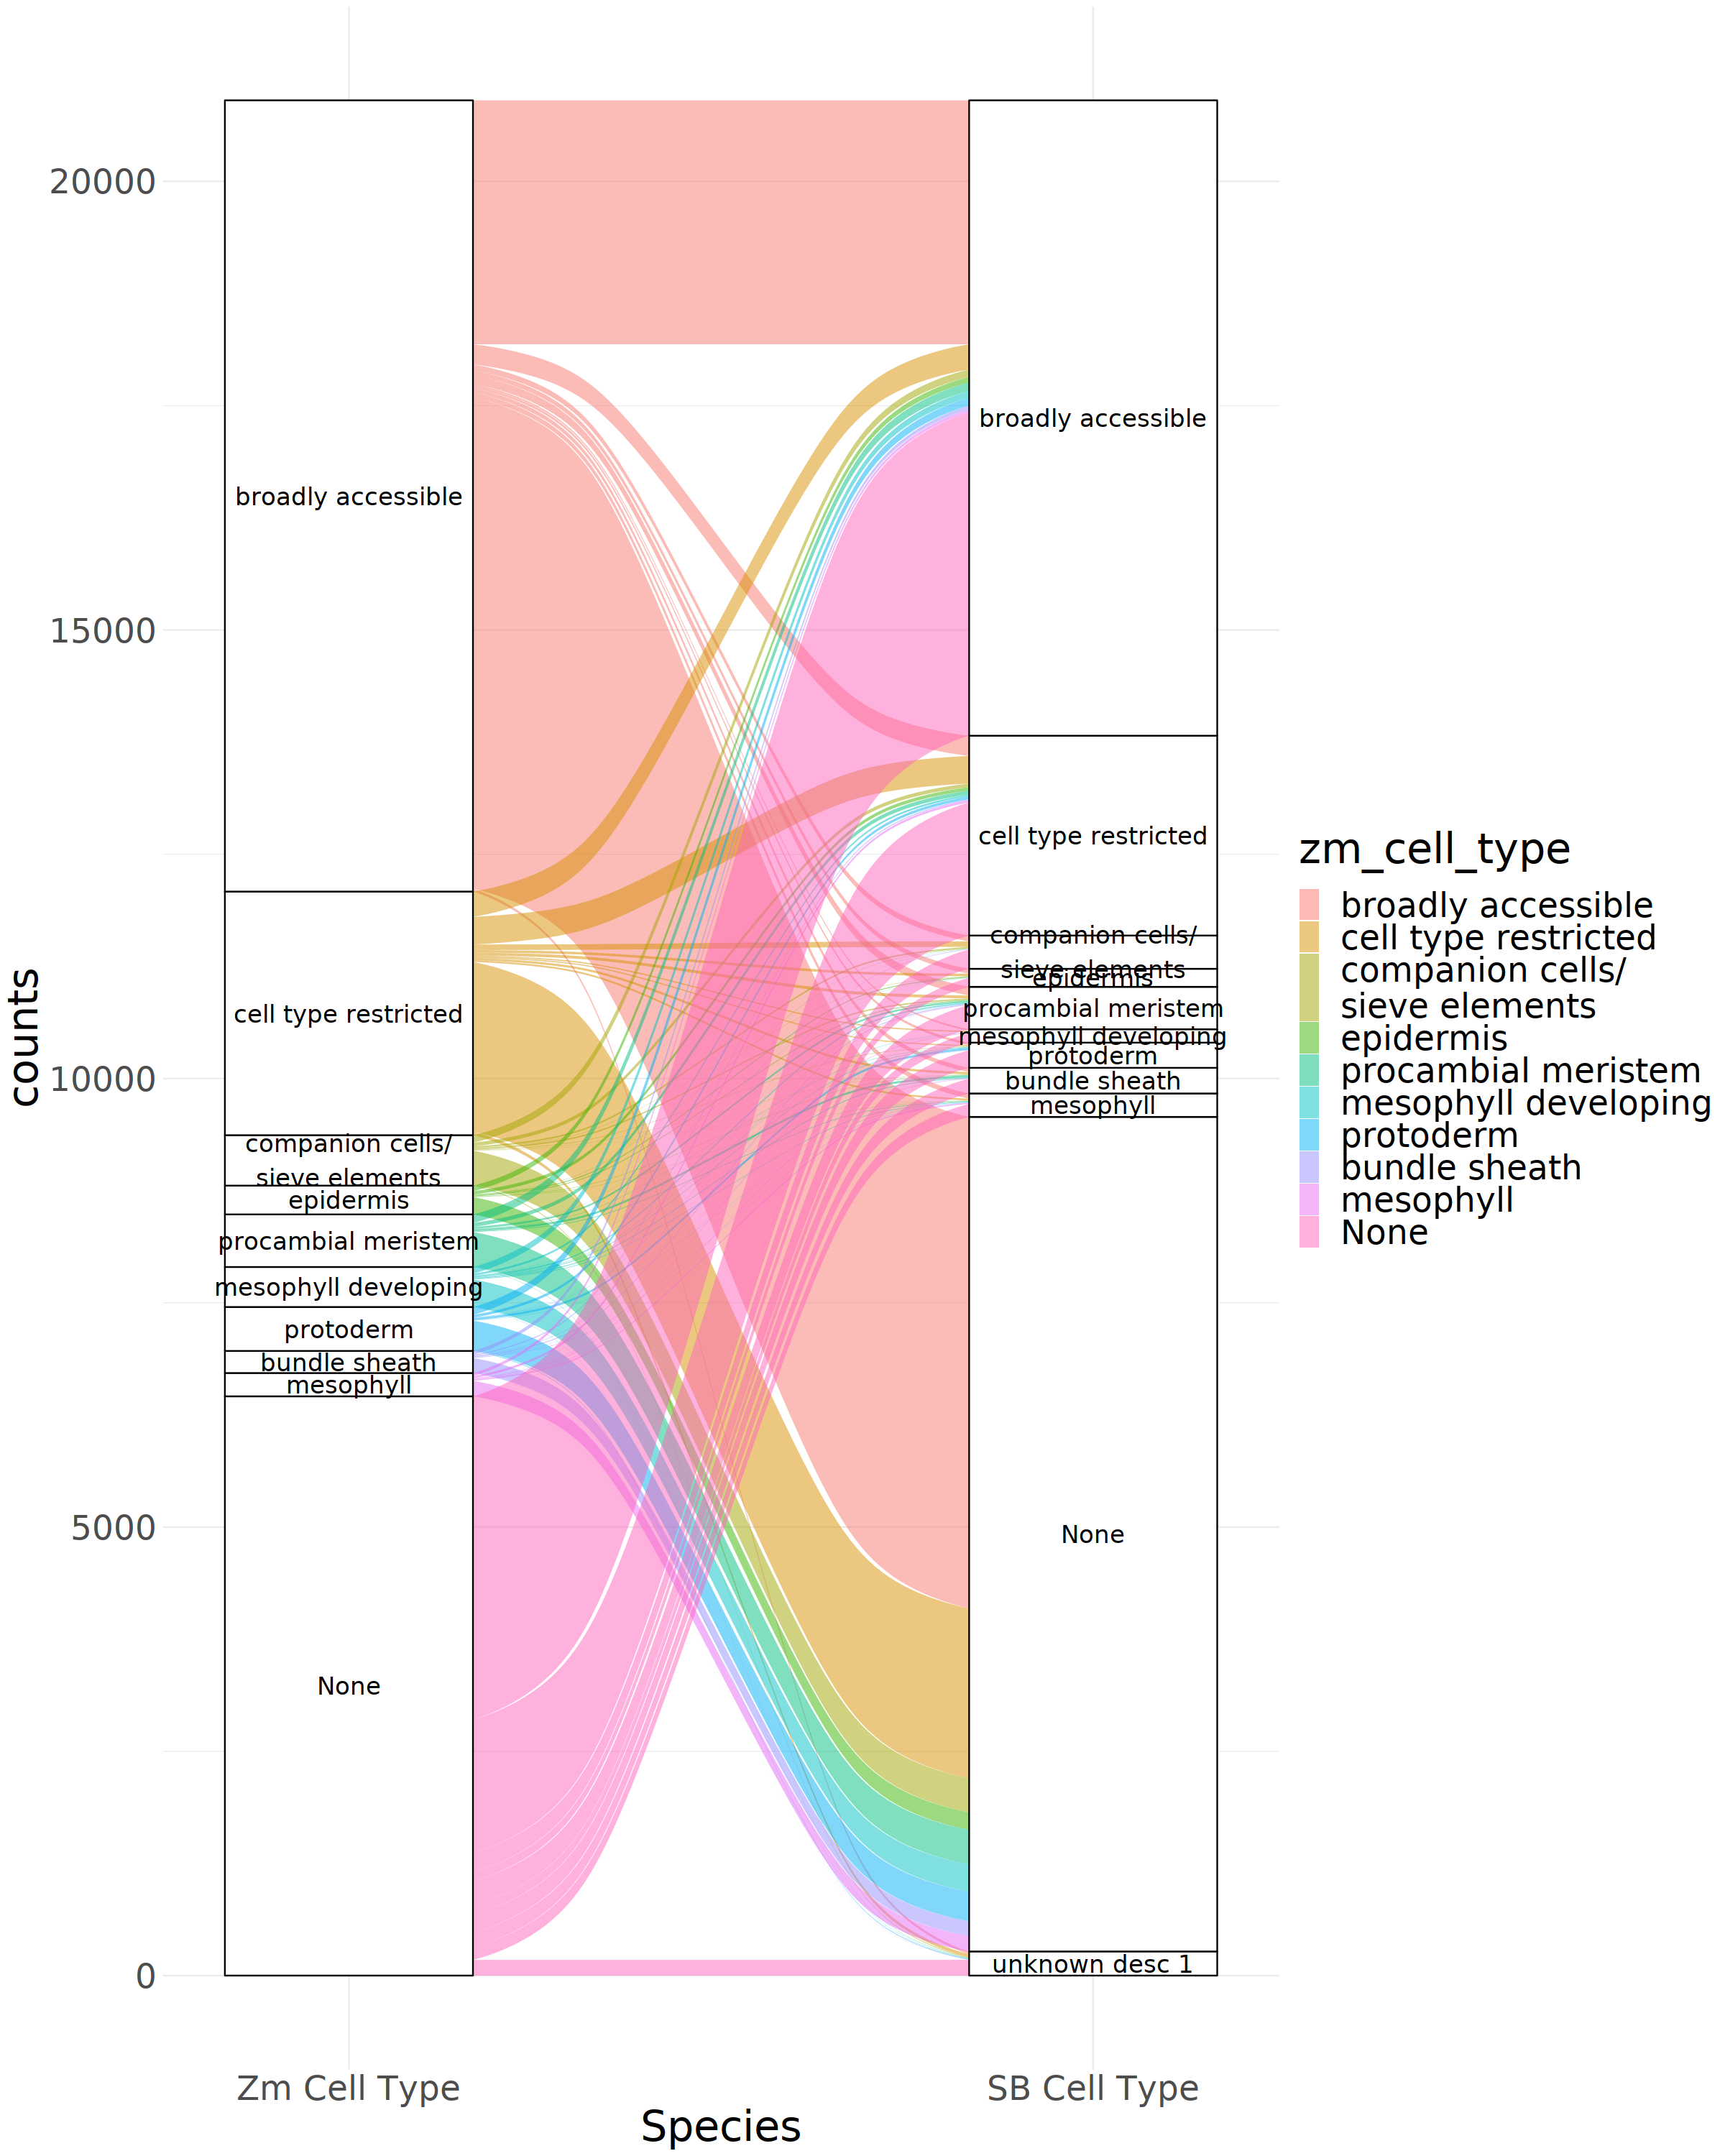

In [37]:

library(ggalluvial)


options(repr.plot.width=20, repr.plot.height=25)
ggplot(data = yy,
       aes(axis1 = zm_cell_type, axis2 = sb_cell_type,
           y = counts)) +
  scale_x_discrete(limits = c("Zm Cell Type", "SB Cell Type"), expand = c(.2, .05)) +
  xlab("Species") +
  geom_alluvium(aes(fill = zm_cell_type)) +
  geom_stratum() +
  geom_text(size=7, stat = "stratum", aes(label = after_stat(stratum))) +
  theme_minimal() + theme(text = element_text(size = 35))


Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”


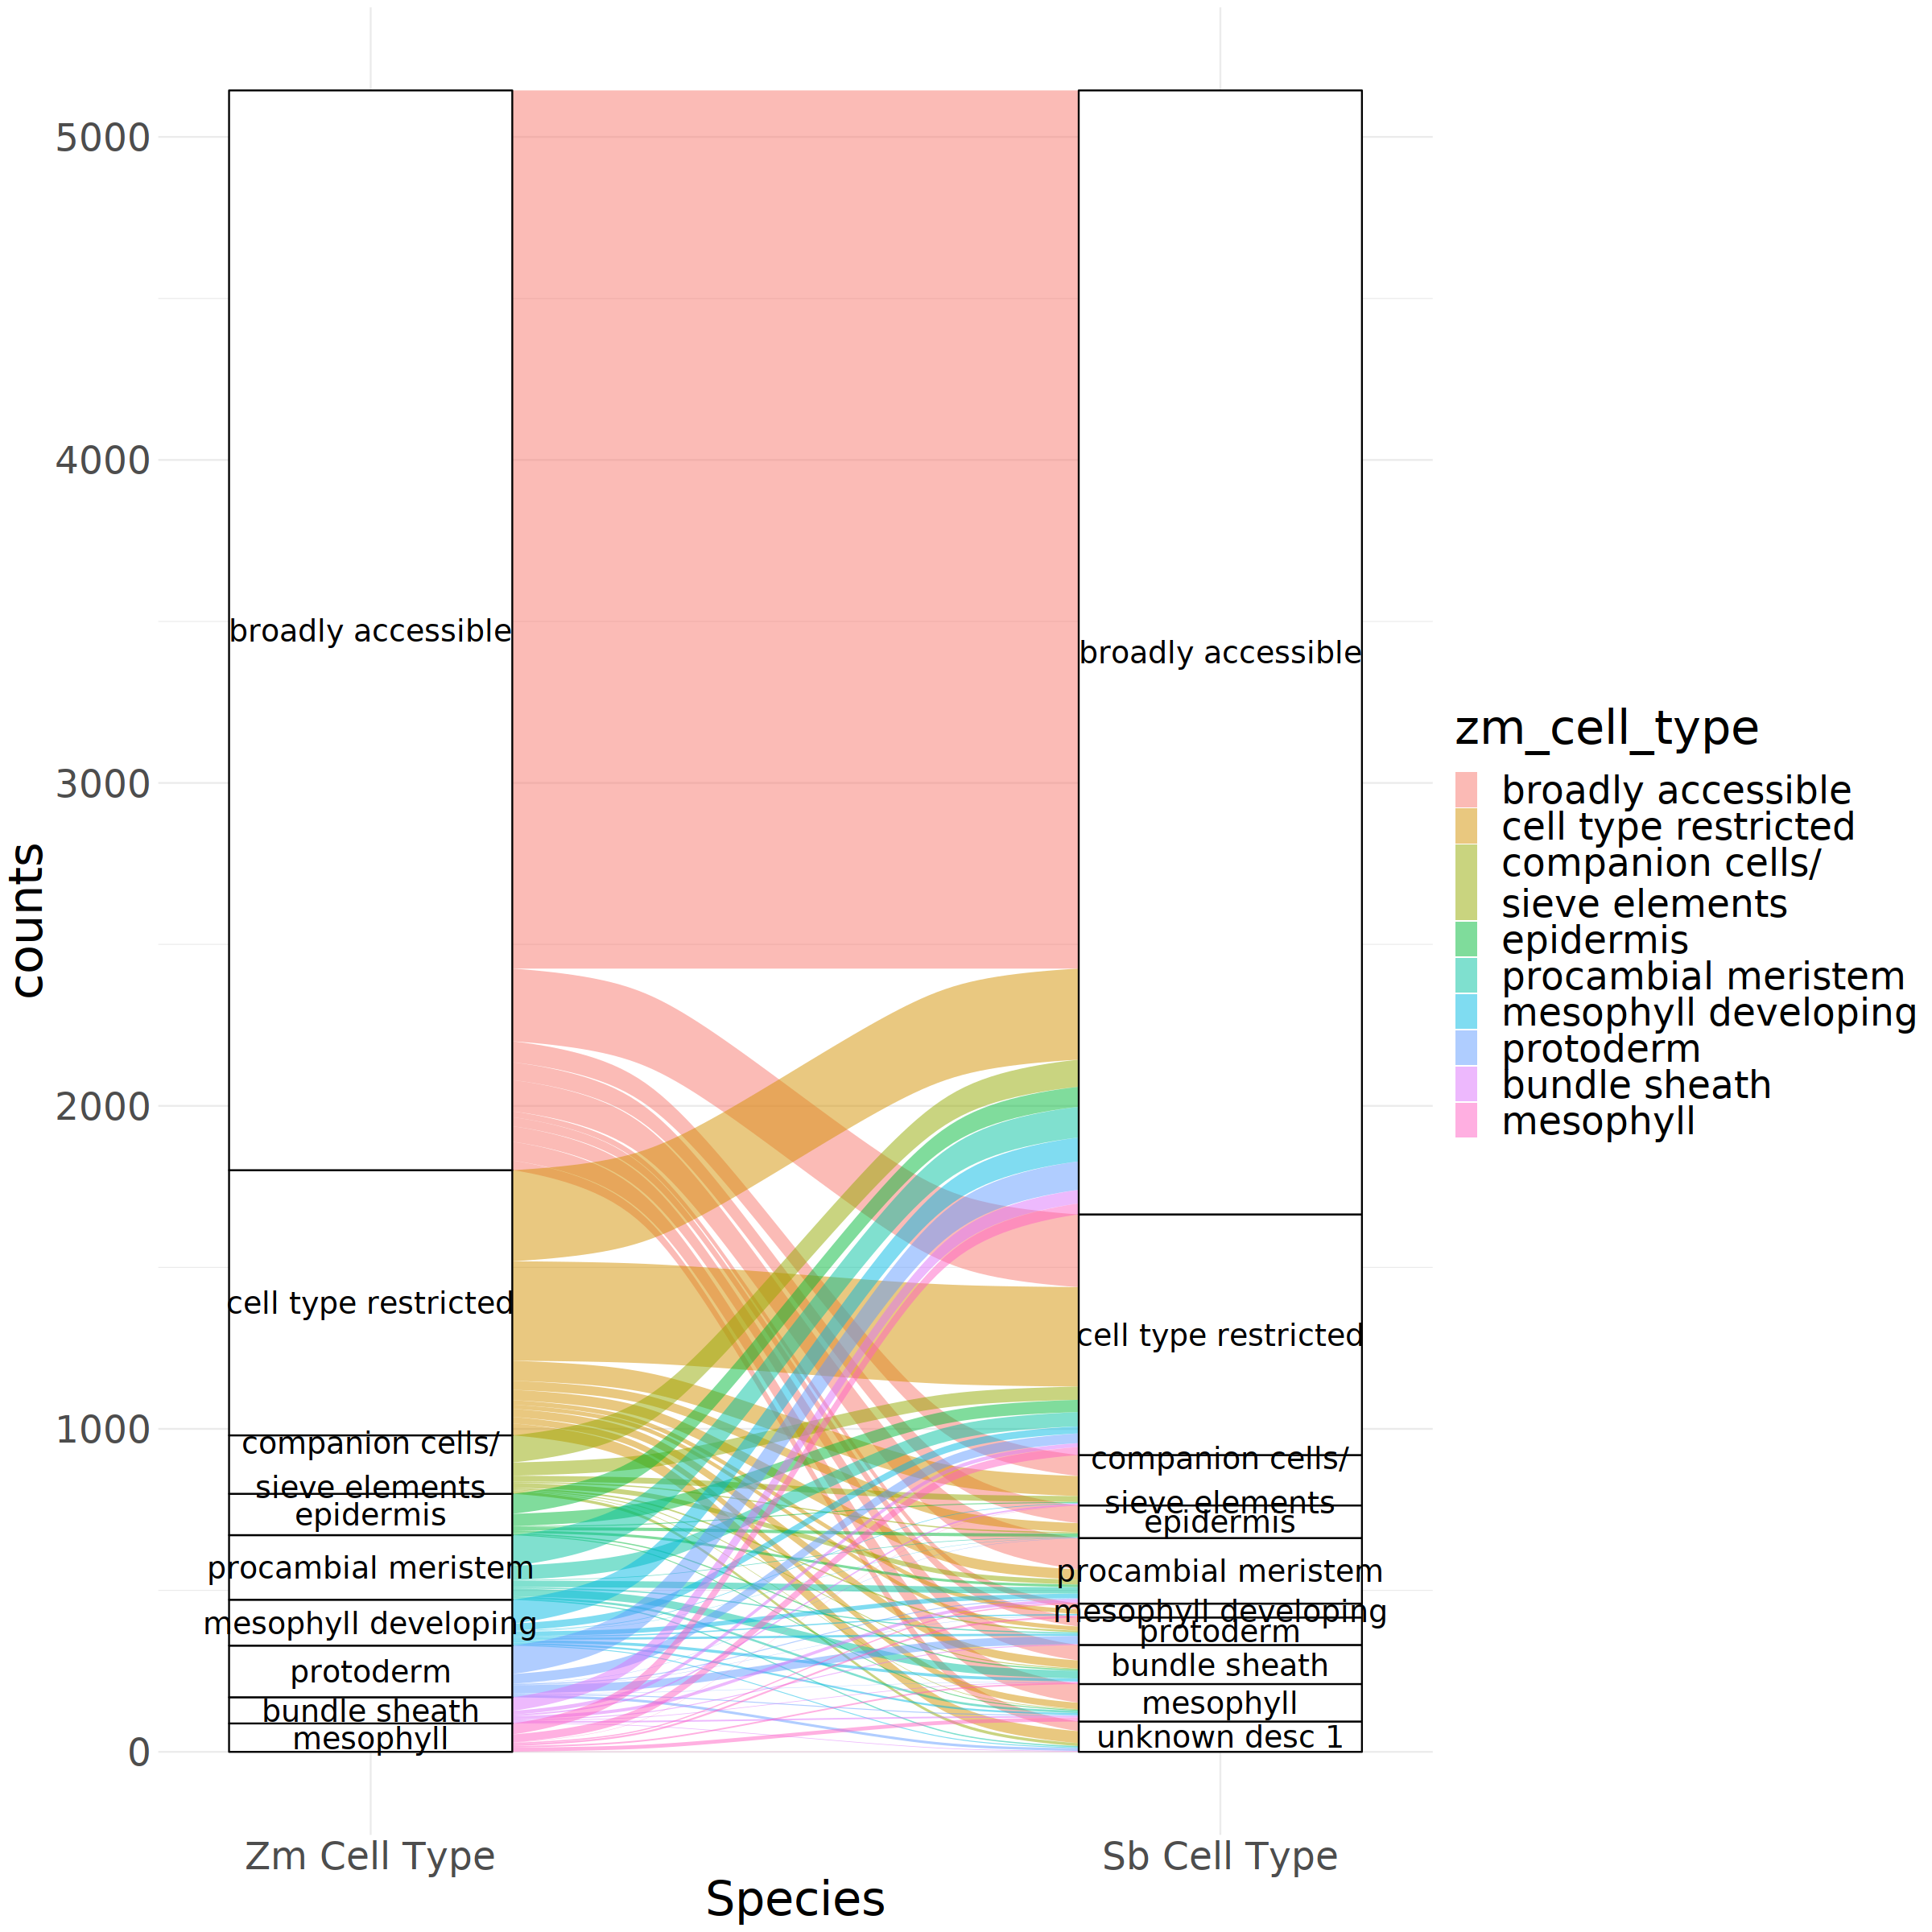

In [38]:

library(ggalluvial)


options(repr.plot.width=20, repr.plot.height=20) 
yy  %>% 
    dplyr::filter(zm_cell_type != "None")  %>% 
    dplyr::filter(sb_cell_type != "None")  %>% 
    ggplot(.,
       aes(axis1 = zm_cell_type, axis2 = sb_cell_type,
           y = counts)) +
  scale_x_discrete(limits = c("Zm Cell Type", "Sb Cell Type"), expand = c(.2, .05)) +
   xlab("Species") +
  geom_alluvium(aes(fill = zm_cell_type)) +
  geom_stratum() +
  geom_text(size=8, stat = "stratum", aes(label = after_stat(stratum))) +
  theme_minimal() + theme(text = element_text(size = 35))


Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”


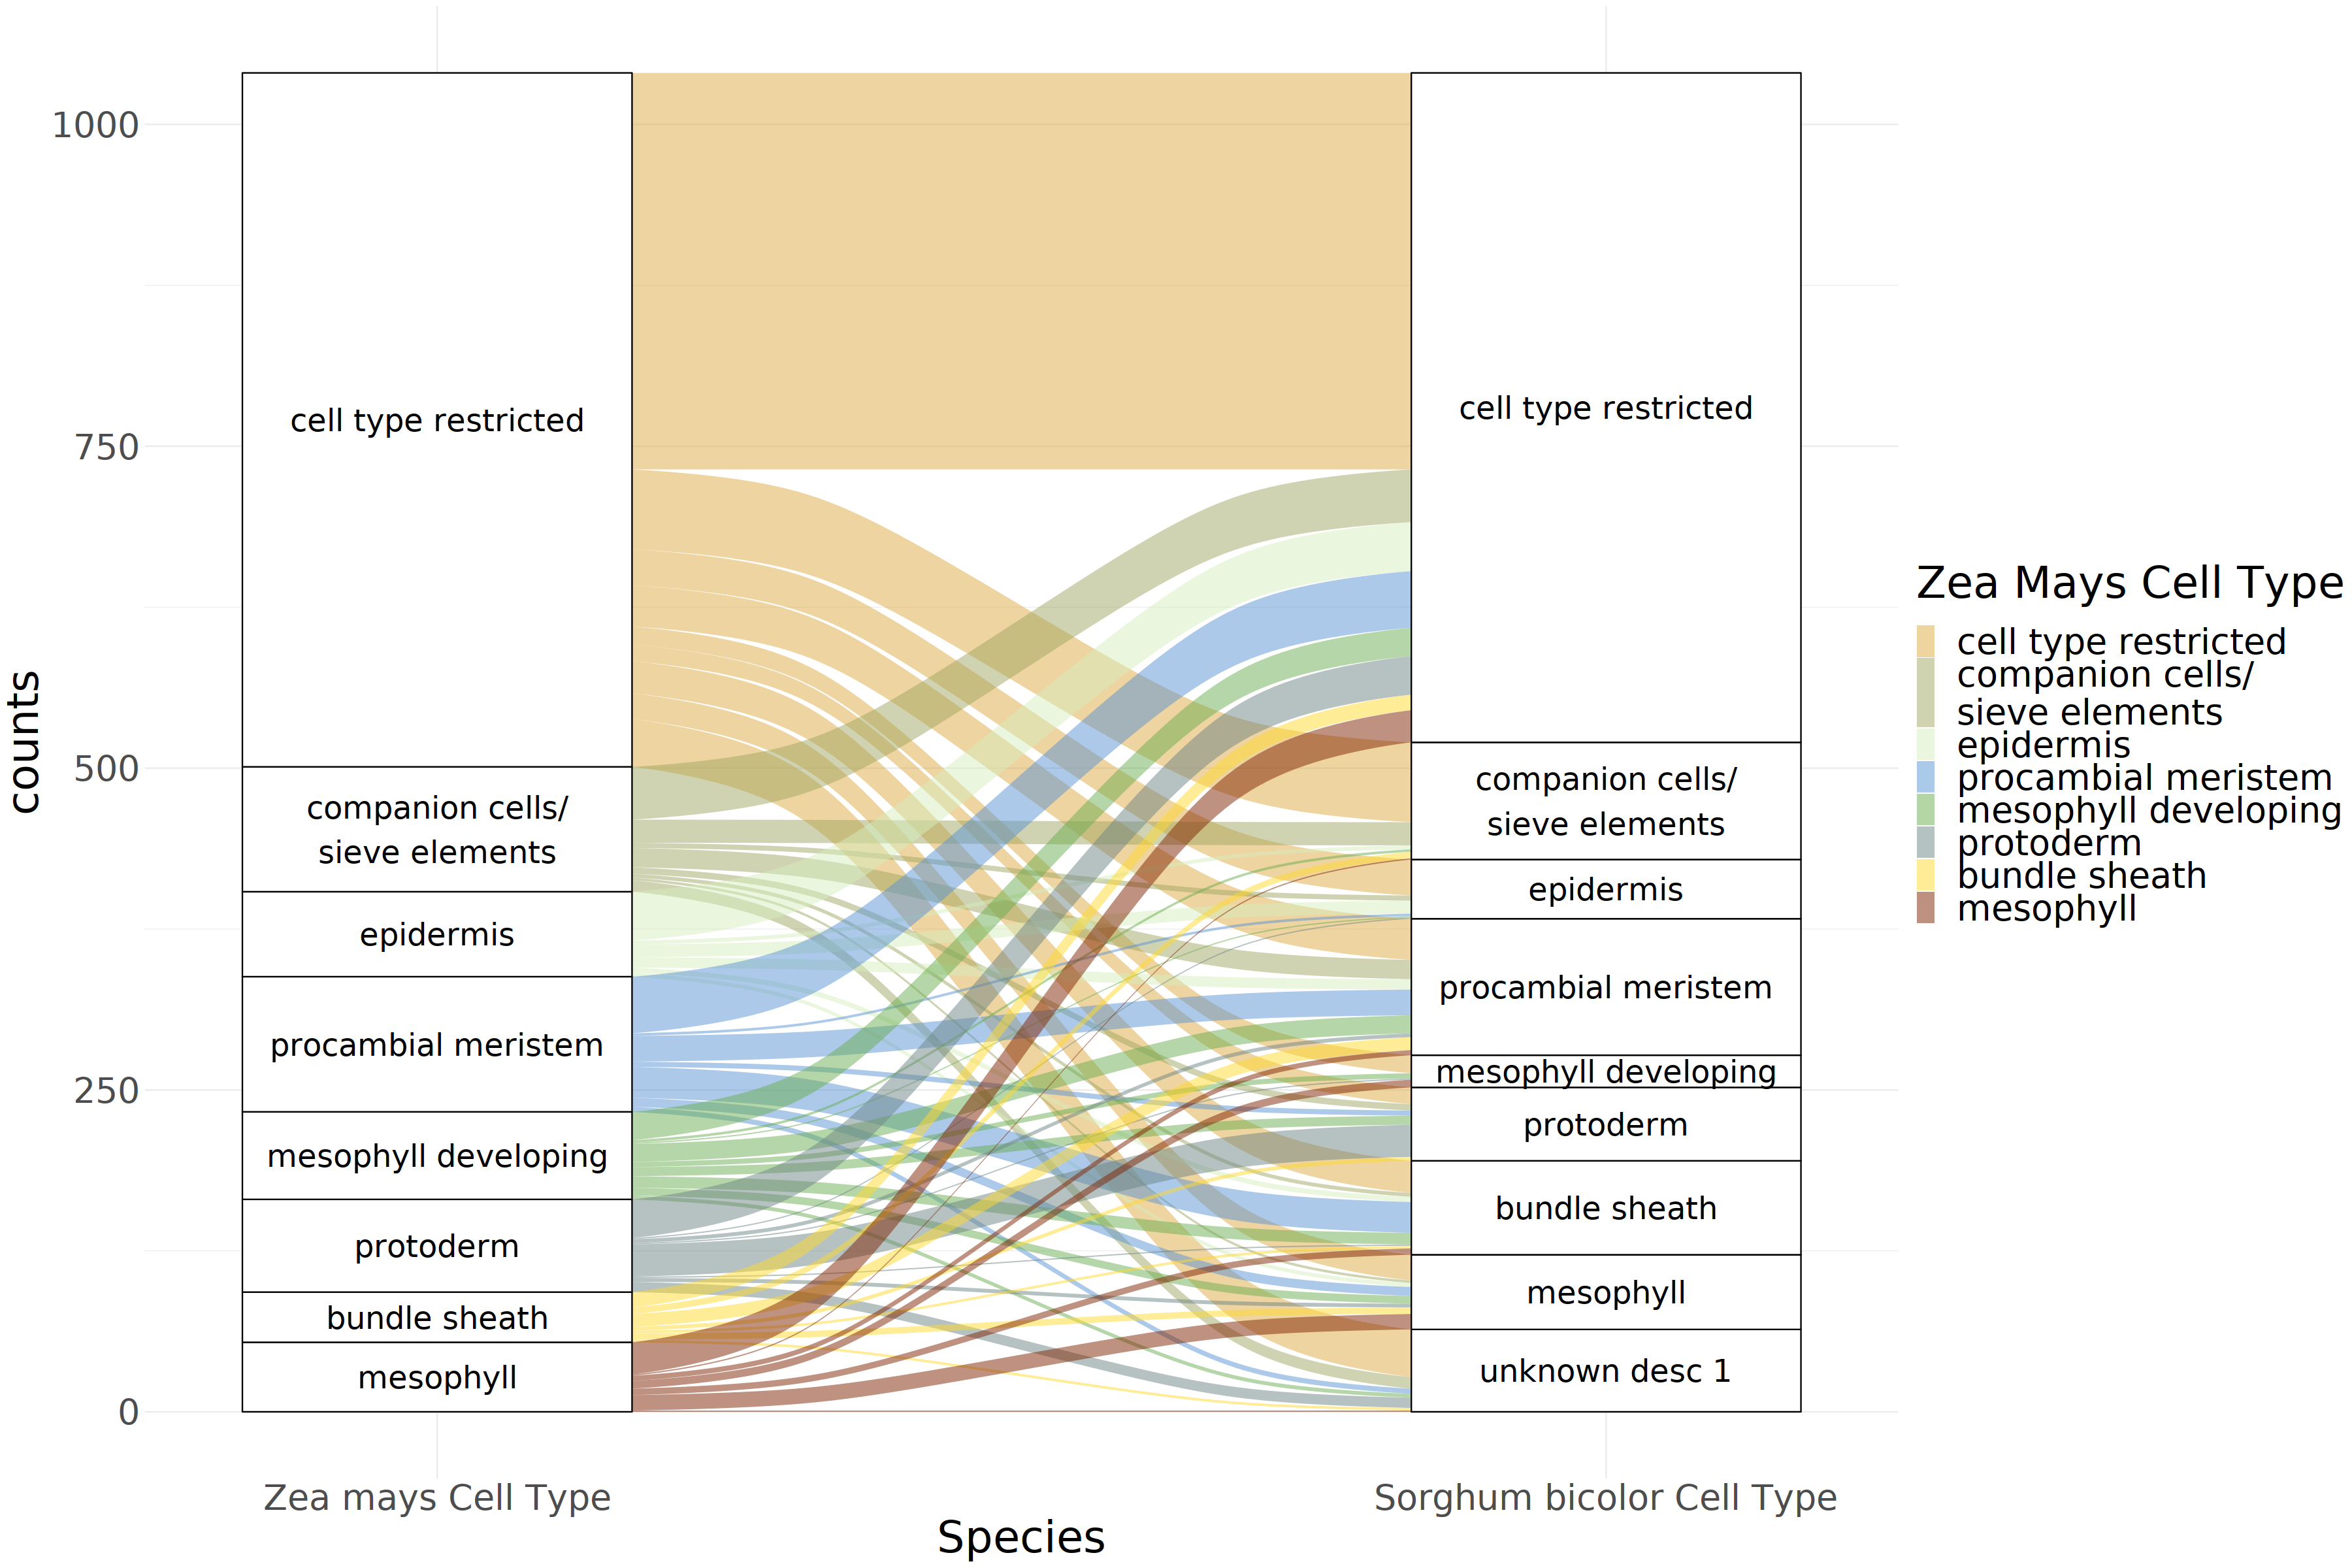

In [39]:

library(ggalluvial)


options(repr.plot.width=30, repr.plot.height=20) 
lt <-   'Zea Mays Cell Type'

yy  %>% 
    dplyr::filter(zm_cell_type != "None")  %>% 
    dplyr::filter(zm_cell_type != "broadly accessible" & sb_cell_type != "broadly accessible")  %>% 
    dplyr::filter(sb_cell_type != "None")  %>% 

    ggplot(.,
       aes(axis1 = zm_cell_type, axis2 = sb_cell_type,
           y = counts)) +
  scale_x_discrete(limits = c("Zea mays Cell Type", "Sorghum bicolor Cell Type"), expand = c(.2, .05)) +
  xlab("Species") +
  geom_alluvium(aes(fill = zm_cell_type)) +
  geom_stratum(alpha = 1) +

  geom_text(size=10, stat = "stratum", aes(label = after_stat(stratum))) +
  theme_minimal() + theme(text = element_text(size = 40)) + 
  scale_fill_manual(lt, values = colors_large)




In [40]:
joined_ACRs_by_CNS <- yy <- full_join(zm_cts_cns, sb_cts_cns, by = c("cns_ID"))  %>% 
    replace(is.na(.), "None")  %>% 
    mutate(counts = 1)


x <- pivot_wider(joined_ACRs_by_CNS, names_from = c(zm_cell_type), values_from = counts)
head(x)

Warning message:
“Values from `counts` are not uniquely identified; output will contain list-cols.
* Use `values_fn = list` to suppress this warning.
* Use `values_fn = {summary_fun}` to summarise duplicates.
* Use the following dplyr code to identify duplicates.
  {data} %>%
    dplyr::group_by(cns_ID, sb_cell_type, zm_cell_type) %>%
    dplyr::summarise(n = dplyr::n(), .groups = "drop") %>%
    dplyr::filter(n > 1L)”


cns_ID sb_cell_type broadly_accessible cell_type_restricted
1 CNS_36 None         1                  NULL                
2 CNS_37 None         1                  NULL                
3 CNS_63 None         1                  NULL                
4 CNS_79 None         NULL               1                   
5 CNS_87 None         1                  NULL                
6 CNS_88 None         1                  NULL                
  phloem_sieve_elements epidermis procambial_meristem mesophyll_desc_developing
1 NULL                  NULL      NULL                NULL                     
2 NULL                  NULL      NULL                NULL                     
3 NULL                  NULL      NULL                NULL                     
4 NULL                  NULL      NULL                NULL                     
5 NULL                  NULL      NULL                NULL                     
6 NULL                  NULL      NULL                NULL                     
  companion_cells protoderm bundle_sheath mesophyll None
1 NULL            NULL      NULL          NULL      NULL
2 NULL            NULL      NULL          NULL      NULL
3 NULL            NULL      NULL          NULL      NULL
4 NULL            NULL      NULL          NULL      NULL
5 NULL            NULL      NULL          NULL      NULL
6 NULL            NULL      NULL          NULL      NULL

In [44]:
x <- full_join(zm_cts_cns, sb_cts_cns, by = c("cns_ID"))  %>% 
    replace(is.na(.), "None") 

In [43]:
CNS_ACR_occuring_twice <- Zm_Sb_CNS_ACR_overlaps.filtered  %>% 
    dplyr::select(cns_ID, acr_chrom, acr_start, acr_stop, cell_type, species)  %>% 
    dplyr::group_by(cns_ID, species) %>%
    dplyr::summarise(n = dplyr::n(), .groups = "drop") %>%
    dplyr::filter(n > 1L)  


`%ni%` <- Negate(`%in%`)
Zm_Sb_CNS_ACR_overlaps_filtered_reformat <-  Zm_Sb_CNS_ACR_overlaps.filtered  %>% 
    dplyr::filter(cns_ID %ni% CNS_ACR_occuring_twice$cns_ID)  %>% 
    pivot_wider(id_cols = cns_ID, names_from = species, 
                values_from = c(acr_chrom, acr_start, acr_stop, cell_type),
                 names_glue = "{species}_{.value}")  


Zm_Sb_CNS_ACR_overlaps_filtered_reformat_arranged <- Zm_Sb_CNS_ACR_overlaps_filtered_reformat %>% 
    dplyr::select(cns_ID, sb_cell_type, zm_cell_type,sb_acr_chrom,  sb_acr_start, sb_acr_stop,
                  zm_acr_chrom, zm_acr_start, zm_acr_stop)





ERROR: [1m[33mError[39m in `dplyr::select()`:[22m
[33m![39m Can't subset columns that don't exist.
[31m✖[39m Column `acr_chrom` doesn't exist.


In [ ]:
Zm_Sb_CNS_ACR_overlaps.filtered  %>% 
    dplyr::filter(cns_ID %in% test$cns_ID)

In [ ]:
filtered_sqitches_conservation <- Zm_Sb_CNS_ACR_overlaps_filtered_reformat_arranged  %>% 
    dplyr::filter(is.na(sb_cell_type) != TRUE)  %>% 
    dplyr::filter(is.na(zm_cell_type) != TRUE)  %>% 
    arrange(zm_cell_type, sb_cell_type)

filtered_sqitches_conservation

In [ ]:
write_tsv(filtered_sqitches_conservation, na = "NA", file = "/home/jpm73279/CNS_ACRs_change.tsv")

In [ ]:
q <- full_join(zm_cts_cns, sb_cts_cns, by = c("cns_ID"))  %>% 
    replace(is.na(.), "None") 